In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import random
import math
import matplotlib.cm as cm
import numpy as np
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
from scipy.cluster.hierarchy import dendrogram
from itertools import chain, combinations

# Complex Network Exam Project

# Train Bombing

This undirected network contains contacts between suspected terrorists involved in the train bombing of Madrid on March 11, 2004 as reconstructed from newspapers. \
A node represents a terrorist and an edge between two terrorists shows that there was a contact between the two terroists. \
The edge weights denote how 'strong' a connection was. This includes four levels of connection strength: friendships, ties to Al Qaeda and Osama Bin Laden, co-participants in wars, and co-participants in previous terrorist attacks.

Link of information about data: http://konect.cc/networks/moreno_train

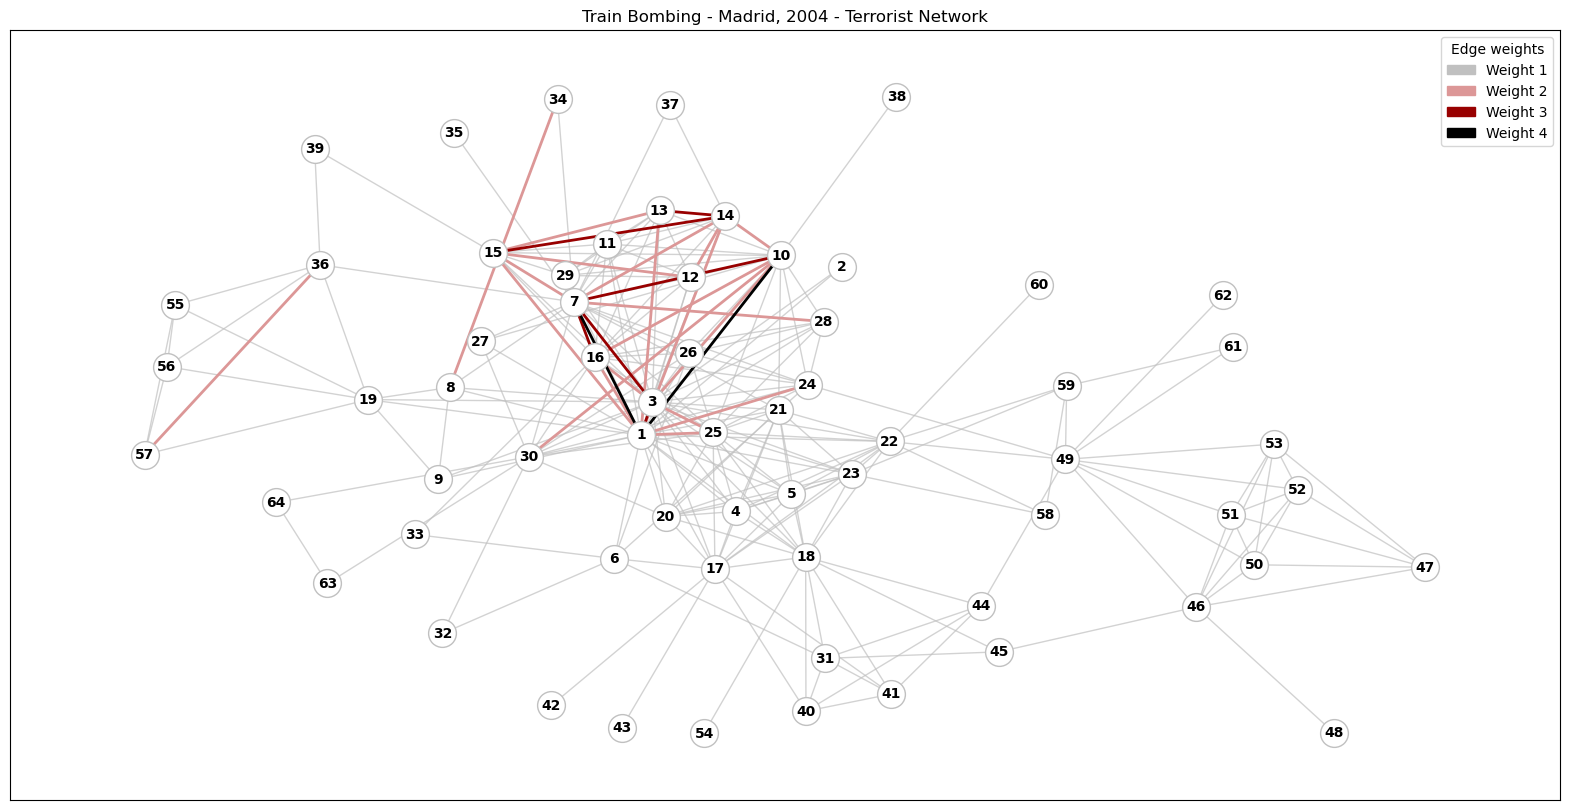

In [2]:
with open(r'moreno_train\out.moreno_train_train', 'r') as file:
    train = file.readlines()
train = [t.replace('\n', '') for t in train[2:]]
edges = [(int(t.split()[0]), int(t.split()[1])) for t in train]
weights = [int(t.split()[2]) for t in train]

G = nx.Graph() 
for e,w in zip(edges,weights):
    G.add_edge(e[0], e[1], weight=w)

plt.figure(figsize=(20,10))

pos = nx.kamada_kawai_layout(G)
nx.draw_networkx_nodes(G, pos=pos, node_size=400, node_color='white', linewidths=1, edgecolors='#C0C0C0')
nx.draw_networkx_labels(G, pos=pos, labels={n:n for n in G}, font_size=10, font_color='black', font_weight='bold')

weights = [1,2,3,4]
weights_colors = ['#C0C0C0', '#DC9797', '#980000', '#000000']
legend_handles = []
for w, c in zip(weights, weights_colors):
    legend_handles.append(mpatches.Patch(color=c, label=f'Weight {w}'))
    weight_w_edges = [e for e in G.edges if G.get_edge_data(e[0],e[1])['weight'] == w]
    if w == 1:
        nx.draw_networkx_edges(G, pos, edgelist=weight_w_edges, edge_color=c, width=1, alpha=0.7)
    else:
        nx.draw_networkx_edges(G, pos, edgelist=weight_w_edges, edge_color=c, width=2)

plt.title('Train Bombing - Madrid, 2004 - Terrorist Network')

plt.legend(handles=legend_handles, title="Edge weights")
plt.show()


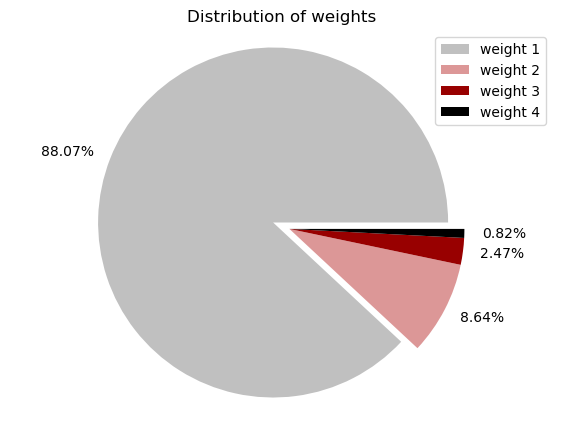

In [3]:
# Number of weights
weights_nr = []
for w in weights:
    weights_nr.append([G.get_edge_data(e[0], e[1])['weight'] for e in G.edges].count(w))

weights_pct = [f'{round(pct,2)}%' for pct in np.array(weights_nr)/sum(weights_nr)*100]

explode = (0.1, 0, 0, 0)  

plt.figure(figsize=(7,5)) 
plt.pie(weights_nr, explode=explode, labels=weights_pct, colors=weights_colors)

plt.title('Distribution of weights')
plt.axis('equal') 
plt.legend([f'weight {w}' for w in weights], loc='upper right')
plt.show()

# Measures

In [4]:
max_deg = max([d[1] for d in G.degree])
max_deg_node = [d[0] for d in G.degree if d[1] == max([d[1] for d in G.degree])]
avg_deg = sum([d[1] for d in G.degree()])/G.number_of_nodes()
nr_singletons = sum([1 for d in G.degree if d[1] == 0])
strengths = dict(zip([n for n in G.nodes], [sum([G.get_edge_data(e[0],e[1])['weight'] for e in edges if n in e]) for n in G.nodes]) )
max_str = max([strengths[n] for n in strengths])
max_str_node = [n for n in strengths if strengths[n] == max_str]
avg_str = round(sum([strengths[n] for n in strengths])/G.number_of_nodes(), 2)
cycles = nx.cycle_basis(G)
nr_cycles = len(cycles)
total_triangles = sum(nx.triangles(G).values()) // 3
    
measures = {
    'Number of nodes': G.number_of_nodes(),
    'Number of edges': G.number_of_edges(),
    'Graph is connected': nx.is_connected(G),
    'Maximum degree': max_deg,
    'Average degree': avg_deg,
    'Number of singletons': nr_singletons,
    'Density': nx.density(G),
    'Max strength': max_str,
    'Average strenght': avg_str,
    'Number of cycles': nr_cycles,
    'Average path length (APL)': nx.average_shortest_path_length(G),
    'Diameter': nx.diameter(G),
    'Number of triangles': total_triangles,
    'Clustering coefficient': nx.transitivity(G)
}

df_measures = pd.DataFrame(columns=['Measure', 'Value'])
df_measures['Measure'] = measures.keys()
df_measures['Value'] = measures.values()
df_measures

Measure     Value
0             Number of nodes        64
1             Number of edges       243
2          Graph is connected      True
3              Maximum degree        29
4              Average degree   7.59375
5        Number of singletons         0
6                     Density  0.120536
7                Max strength        43
8            Average strenght      8.81
9            Number of cycles       180
10  Average path length (APL)  2.690972
11                   Diameter         6
12        Number of triangles       527
13     Clustering coefficient  0.561036

# Distance distribution

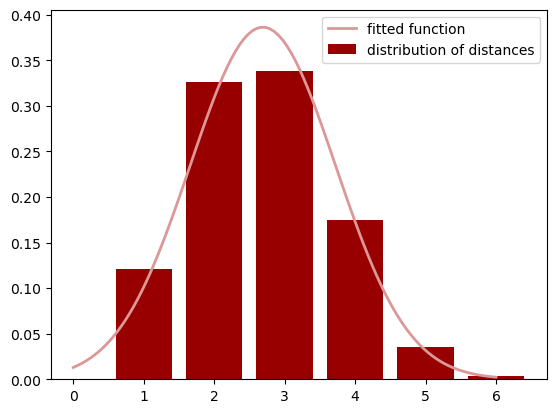

In [5]:
all_lengths = list(np.array([list(l[1].values()) for l in nx.shortest_path_length(G)]).flatten())
# there are no self loops so we consider only positive length
all_lengths = [a for a in all_lengths if a != 0]
lengths = sorted(list(set(all_lengths)))
number_lengths = [all_lengths.count(l) for l in lengths]
# normalization
number_lengths = [n / sum(number_lengths) for n in number_lengths]

avg_length = nx.average_shortest_path_length(G)
sd_length = np.std(all_lengths)

plt.bar(lengths, number_lengths, color='#980000', label='distribution of distances')
x = np.linspace(0, 6, 100)
plt.plot(x, 1/(sd_length * np.sqrt(2 * np.pi)) * np.exp( - (x - avg_length)**2 / (2 * sd_length**2) ), linewidth=2, color='#DC9797', label='fitted function')
plt.legend()
plt.show()

# Small World

The objective is to understand if the grapf G exhibits the “small-world” phenomenon.\
Let's incrementally add nodes to a new graph, starting from 2 up to N=64, and observe how the average path length changes. Initially, we insert nodes with the highest degree.

In [6]:
degrees = list(set(dict(G.degree).values()))

nodes_ordered_by_degree = []
for d in degrees[::-1]:
    nodes_ordered_by_degree += [n for n in G.nodes if G.degree(n) == d]

len(nodes_ordered_by_degree)

64

In [7]:
# weights_colors

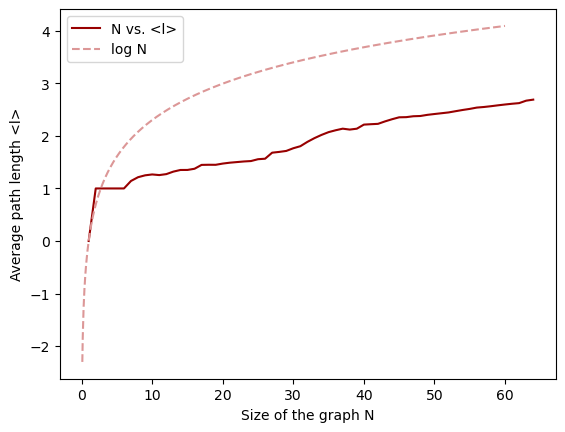

In [8]:
G_small_world = nx.Graph()
size = []
apl = []
for n in nodes_ordered_by_degree:
    G_small_world.add_node(n)
    G_small_world.add_edges_from([e for e in G.edges() if (e[0] in G_small_world.nodes) and (e[1] in G_small_world.nodes)])
    size.append(G_small_world.number_of_nodes())
    apl.append(nx.average_shortest_path_length(G_small_world))

plt.plot(size, apl, color='#980000', label='N vs. <l>')
x = np.linspace(0.1, 60, 1000)
plt.plot(x, np.log(x), linestyle='--', color='#DC9797', label='log N')
plt.xlabel('Size of the graph N')
plt.ylabel('Average path length <l>')
plt.legend()
plt.show()

The average path length does not increase faster then the logarithm of the size. Then graph has the property of "small-world".

# Degree distribution

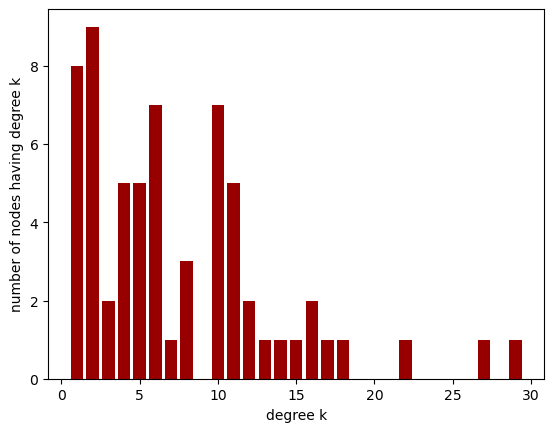

In [9]:
number_nodes_degree = [list(dict(G.degree).values()).count(w) for w in degrees]
freq_degrees = [w / G.number_of_nodes() for w in number_nodes_degree]

plt.bar(degrees, number_nodes_degree, color='#980000')
plt.xlabel('degree k')
plt.ylabel('number of nodes having degree k')
plt.show()

In [10]:
print(f'Average degree = {avg_deg}')
var_deg = sum([d**2 for d in dict(G.degree).values()]) / G.number_of_nodes()
print(f'Variance of degree distribution = {var_deg}')

Average degree = 7.59375
Variance of degree distribution = 95.65625


In [11]:
# heterogeneity parameter
k = var_deg / avg_deg**2
k

1.6588257210113635

# Hubs

In [12]:
max_1 = max(dict(G.degree).values())
max_2 = max([d for d in dict(G.degree).values() if d<max_1])
max_3 = max([d for d in dict(G.degree).values() if d<max_2])
three_max = [max_1, max_2, max_3]
hubs_dict = {m : [n for n in G.nodes if G.degree(n) == m] for m in three_max}
hubs_dict

{29: [1], 27: [3], 22: [7]}

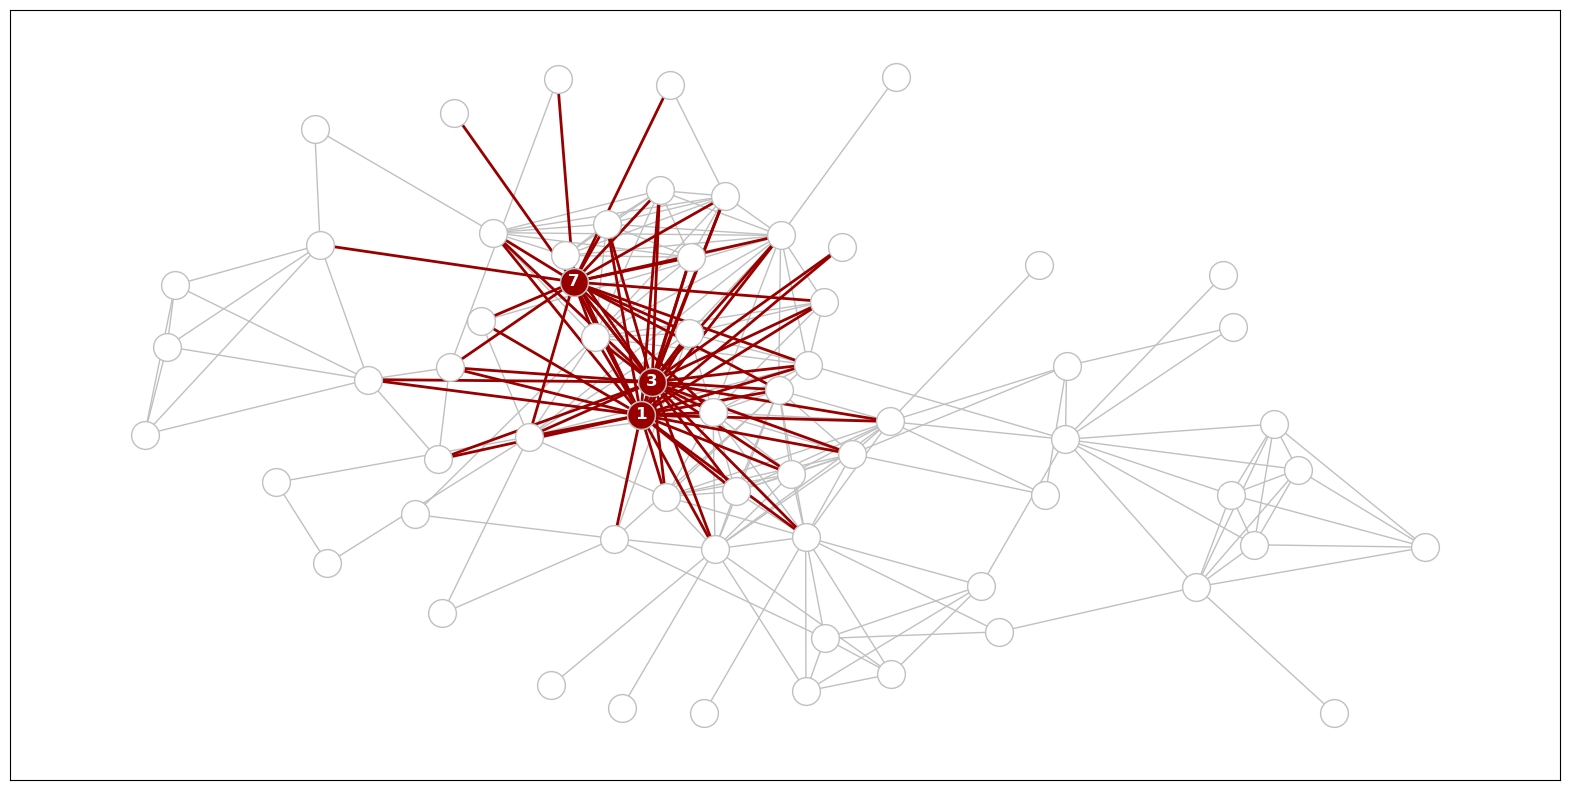

In [13]:
plt.figure(figsize=(20,10))

pos = nx.kamada_kawai_layout(G)
nx.draw_networkx_nodes(G, pos=pos, node_size=400, node_color='white', linewidths=1, edgecolors='#C0C0C0')
nx.draw_networkx_labels(G, pos=pos, labels={n:n for n in G}, font_size=12, font_color='white', font_weight='bold')

hubs = [h[0] for h in hubs_dict.values()]
hub_edges = []
for h in hubs:
    hub_edges += [e for e in G.edges if h in e]
nohub_edges = set(G.edges) - set(hub_edges)
nx.draw_networkx_edges(G, pos, edgelist=nohub_edges, edge_color='#C0C0C0', width=1)
nx.draw_networkx_edges(G, pos, edgelist=hub_edges, edge_color='#980000', width=2)
nx.draw_networkx_nodes(G, pos=pos, nodelist=hubs, node_size=400, node_color='#980000', linewidths=1, edgecolors='#C0C0C0')

plt.show()

# Strength distribution

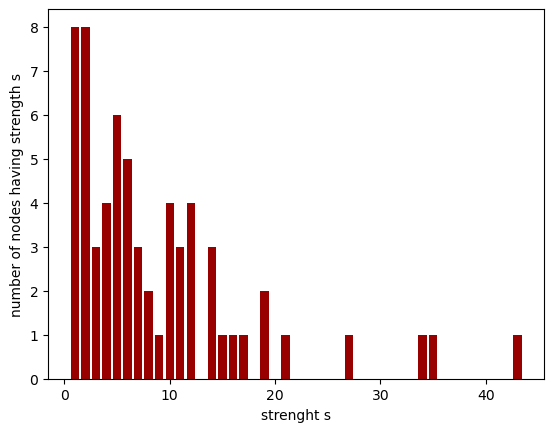

In [14]:
s = sorted(list(set(strengths.values())))
number_nodes_s = [list(strengths.values()).count(s) for s in s]

plt.bar(s, number_nodes_s, color='#980000')
plt.xlabel('strenght s')
plt.ylabel('number of nodes having strength s')
plt.show()

In [15]:
avg_str = sum(strengths.values()) / G.number_of_nodes()
print(f'Average strength = {avg_str}')
var_str = sum([s**2 for s in strengths.values()]) / G.number_of_nodes()
print(f'Variance of strength distribution = {var_str}')

Average strength = 8.8125
Variance of strength distribution = 150.5625


The nodes 1, 3 and 7 can be considered hubs, since thay have high degree (29, 27 and 22 respectively). 

# Degree and strangth comparison

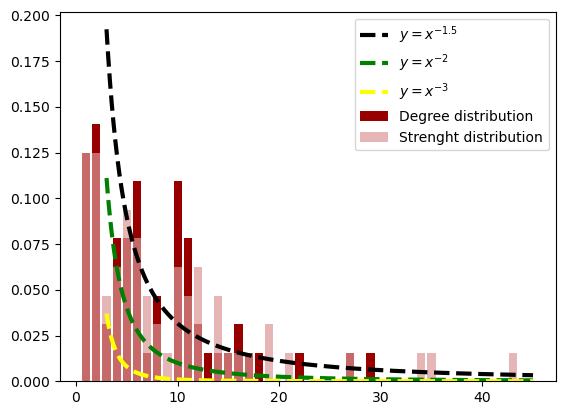

In [16]:
plt.bar(degrees, np.array(number_nodes_degree)/sum(number_nodes_degree), color='#980000', label='Degree distribution')
plt.bar(s, np.array(number_nodes_s)/sum(number_nodes_s), color='#DC9797', label='Strenght distribution', alpha=0.7)

c = 1.5
x = np.linspace(3, 45, 1000)
y = x**(-c)
plt.plot(x,y, linestyle='--', linewidth=3, color='black', label='$y = x^{-1.5}$')

c = 2
x = np.linspace(3, 45, 1000)
y = x**(-c)
plt.plot(x,y, linestyle='--', linewidth=3, color='green', label='$y = x^{-2}$')

c = 3
x = np.linspace(3, 45, 1000)
y = x**(-c)
plt.plot(x,y, linestyle='--', linewidth=3, color='yellow', label='$y = x^{-3}$')

plt.legend()
plt.show()


In [17]:
df_cl_coeff = pd.DataFrame(columns=['Node i1', 'C(i)1', 'Node i2', 'C(i)2', 'Node i3', 'C(i)3', 'Node i4', 'C(i)4'])
df_cl_coeff['Node i1'] = list(nx.clustering(G).keys())[:16]
df_cl_coeff['C(i)1'] = list(nx.clustering(G).values())[:16]
df_cl_coeff['Node i2'] = list(nx.clustering(G).keys())[16:32]
df_cl_coeff['C(i)2'] = list(nx.clustering(G).values())[16:32]
df_cl_coeff['Node i3'] = list(nx.clustering(G).keys())[32:48]
df_cl_coeff['C(i)3'] = list(nx.clustering(G).values())[32:48]
df_cl_coeff['Node i4'] = list(nx.clustering(G).keys())[48:]
df_cl_coeff['C(i)4'] = list(nx.clustering(G).values())[48:]
df_cl_coeff

Node i1     C(i)1  Node i2     C(i)2  Node i3     C(i)3  Node i4     C(i)4
0         1  0.332512       17  0.466667       33  0.000000       57  1.000000
1         2  1.000000       18  0.450000       34  1.000000       49  0.218182
2         3  0.367521       19  0.428571       35  0.000000       58  1.000000
3         4  1.000000       20  0.872727       36  0.400000       59  0.500000
4         5  1.000000       21  0.787879       37  1.000000       60  0.000000
5         6  0.190476       22  0.538462       38  0.000000       63  1.000000
6         7  0.367965       23  0.727273       39  0.000000       64  1.000000
7         8  0.600000       24  0.672727       40  0.800000       46  0.500000
8         9  1.000000       25  0.602941       41  0.800000       47  1.000000
9        10  0.529412       26  0.822222       42  0.000000       48  0.000000
10       11  1.000000       27  1.000000       43  0.000000       50  0.933333
11       12  1.000000       28  1.000000       44  0.600000       51  0.933333
12       13  1.000000       29  1.000000       45  0.333333       52  0.933333
13       14  0.836364       30  0.448718       54  0.000000       53  0.933333
14       15  0.818182       31  0.466667       55  1.000000       61  1.000000
15       16  0.616667       32  0.000000       56  1.000000       62  0.000000

# clustering coefficient distribution

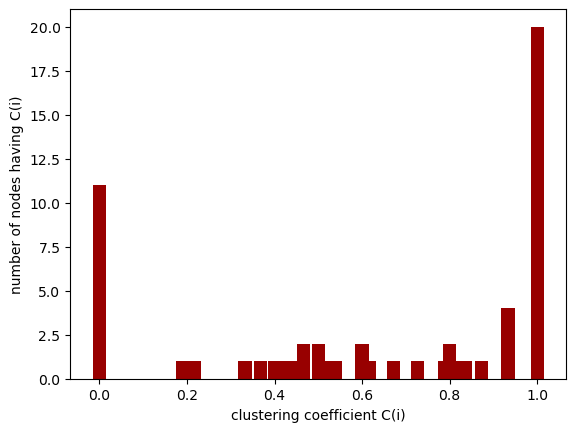

In [18]:
cl_coeff = sorted(list(set(nx.clustering(G).values())))
number_nodes_cl_coeff = [list(nx.clustering(G).values()).count(c) for c in cl_coeff]
plt.bar(cl_coeff, number_nodes_cl_coeff, color='#980000', width=0.03)
plt.xlabel('clustering coefficient C(i)')
plt.ylabel('number of nodes having C(i)')
plt.show()

# Robustness
A system is robust if the failure (removal of a node or edge) of some of its components does not affect its function.

In [19]:
len(G)

64

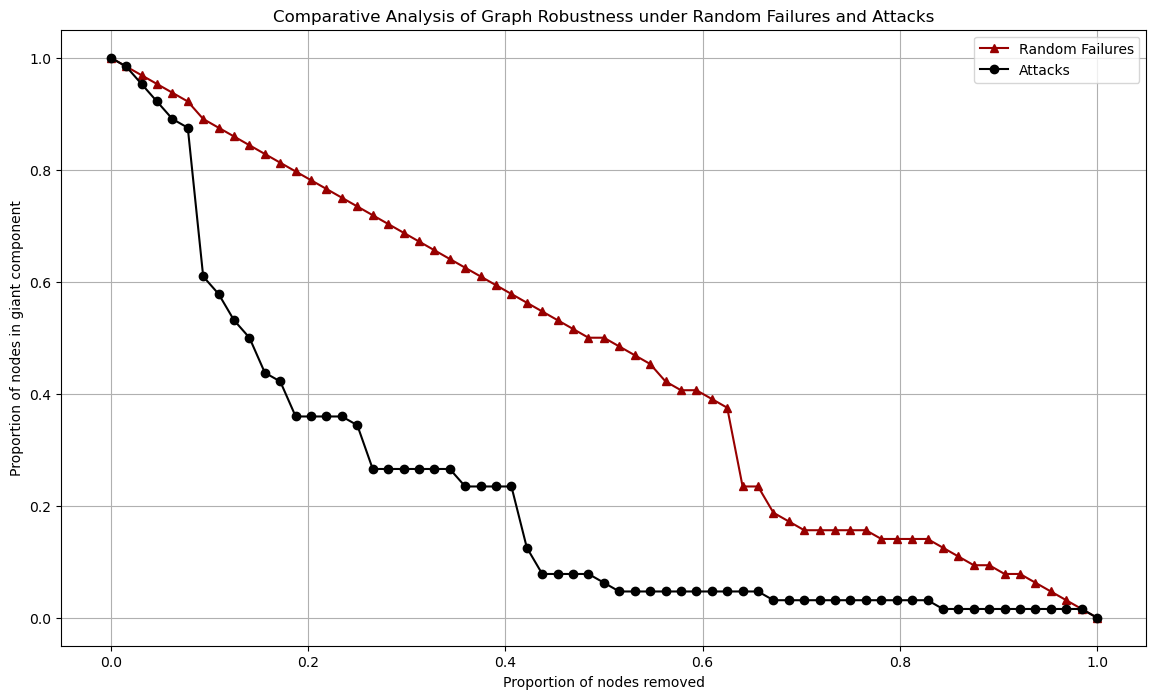

In [20]:
# Random failures: nodes break down randomly, so they are all chosen with the same probability
def measure_robustness_random(G):
    G_copy = G.copy() 
    nodes = list(G_copy.nodes())
    random.shuffle(nodes)  
    
    giant_component_sizes = []
    removed_nodes = []
    
    for node in nodes:
        G_copy.remove_node(node)
        removed_nodes.append(node)
        if len(G_copy) == 0:
            giant_component_sizes.append(0)
        else:
            largest_component = max(nx.connected_components(G_copy), key=len)
            giant_component_sizes.append(len(largest_component))
        
        
    return removed_nodes, giant_component_sizes

# Attacks: hubs are deliberately targeted — the larger the degree, the higher the probability of removing the node
def measure_robustness_by_degree(G):
    G_copy = G.copy()
    nodes = sorted(G_copy.nodes(), key=lambda n: G_copy.degree(n), reverse=True)  # Ordina per grado decrescente
    component_sizes = []
    removed_nodes = []
    
    for node in nodes:
        G_copy.remove_node(node)
        if len(G_copy) == 0:
            component_sizes.append(0)
        else:
            largest_component = max(nx.connected_components(G_copy), key=len)
            component_sizes.append(len(largest_component))
        removed_nodes.append(node)
        
    return removed_nodes, component_sizes



component_sizes_random = measure_robustness_random(G)[1]
component_sizes_by_degree = measure_robustness_by_degree(G)[1]

initial_size = len(max(nx.connected_components(G), key=len))
component_sizes_random = [initial_size] + component_sizes_random
component_sizes_by_degree = [initial_size] + component_sizes_by_degree

x_random = np.array(range(len(component_sizes_random))) / len(G)
y_random = np.array(component_sizes_random) / initial_size

x_degree = np.array(range(len(component_sizes_by_degree))) / len(G)
y_degree = np.array(component_sizes_by_degree) / initial_size

plt.figure(figsize=(14, 8))
plt.plot(x_random, y_random, '^-', label='Random Failures', color='#980000')
plt.plot(x_degree, y_degree, 'o-', label='Attacks', color='black')
plt.xlabel('Proportion of nodes removed')
plt.ylabel('Proportion of nodes in giant component')
plt.title('Comparative Analysis of Graph Robustness under Random Failures and Attacks')
plt.legend()

plt.grid(True)
plt.show()

# Local Bridges

In [21]:
# neighborhood overlap

def neighborhood_overlap(G, a, b): 
    neighbors_a = set(G.neighbors(a))
    neighbors_b = set(G.neighbors(b))

    neighbors_a.discard(b)
    neighbors_b.discard(a)

    intersection = neighbors_a & neighbors_b
    union = neighbors_a | neighbors_b

    if not union:
        return 0
    
    overlap = len(intersection) / len(union)
    return round(overlap, 3)

# local bridge

def find_local_bridges(G):
    local_bridges = []
    for edge in G.edges:
        if neighborhood_overlap(G, edge[0], edge[1]) == 0:
            local_bridges.append(edge)
    return local_bridges

local_bridges = find_local_bridges(G)
local_bridges

[(6, 31),
 (6, 32),
 (6, 33),
 (7, 35),
 (7, 36),
 (10, 38),
 (15, 39),
 (16, 33),
 (17, 42),
 (17, 43),
 (18, 54),
 (22, 60),
 (24, 49),
 (30, 32),
 (36, 39),
 (44, 49),
 (45, 46),
 (49, 62),
 (46, 48)]

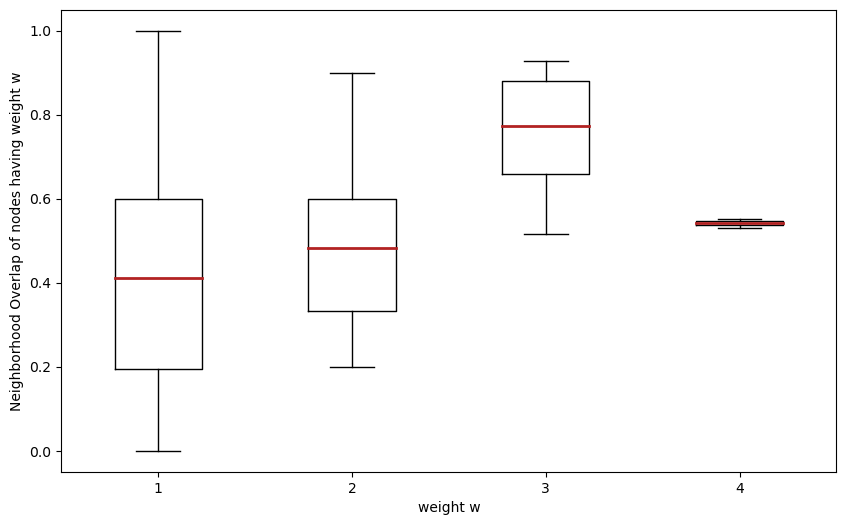

In [22]:
# weigth vs. neighborhhod overlap

weights = set([G.get_edge_data(e[0],e[1])['weight'] for e in G.edges])
overlap_by_weight = {weight: [neighborhood_overlap(G, e[0], e[1]) for e in G.edges if G.get_edge_data(e[0],e[1])['weight'] == weight] for weight in weights}
box_plot_data = [overlap_by_weight[weight] for weight in weights]
plt.figure(figsize=(10, 6))

medianprops = dict(linestyle='-', linewidth=2, color='firebrick')

plt.boxplot(box_plot_data, labels=weights, medianprops=medianprops)
plt.xlabel('weight w')
plt.ylabel('Neighborhood Overlap of nodes having weight w')
plt.show()

In [23]:
# structural hole: node with multiple local bridges

node_local_bridge = set([e[0] for e in local_bridges] + [e[1] for e in local_bridges])

nr_occurences = []
for n in node_local_bridge:
    count = 0
    for e in local_bridges:
        if n in e:
            count += 1
    nr_occurences.append(count)

dict_node_nrLocBridge = dict(zip(node_local_bridge, nr_occurences))
max_locBridge = max(dict_node_nrLocBridge.values())

structural_hole = [node for node in dict_node_nrLocBridge if dict_node_nrLocBridge[node] == max_locBridge]
structural_hole

[6, 49]

In [24]:
# embeddedness: number of common neighbors the two endpoints have

def embeddedness(G, a, b): 
    neighbors_a = set(G.neighbors(a))
    neighbors_b = set(G.neighbors(b))

    neighbors_a.discard(b)
    neighbors_b.discard(a)

    intersection = neighbors_a & neighbors_b

    return len(intersection)

embeddedness_edges = dict(zip(G.edges, [embeddedness(G, edge[0], edge[1]) for edge in G.edges]))


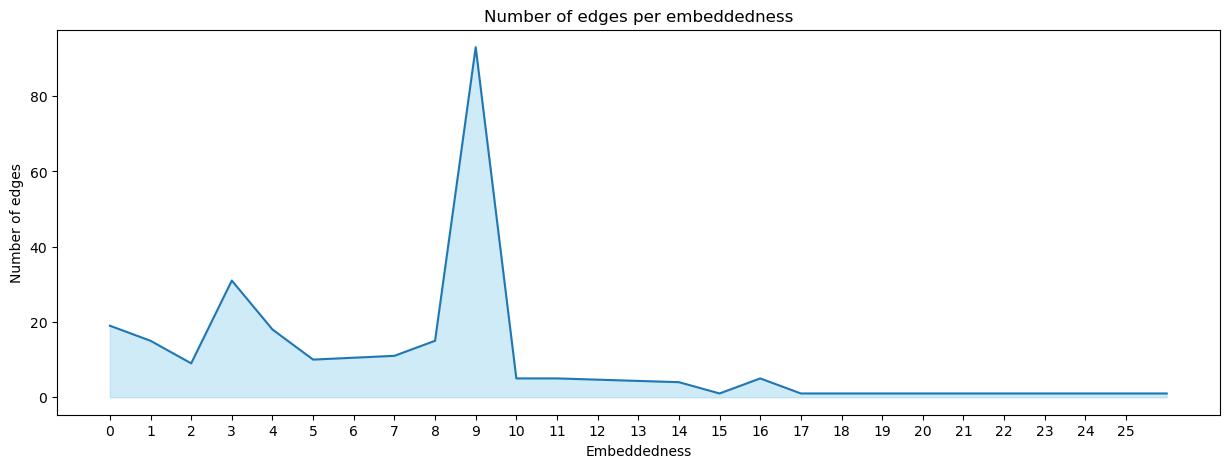

In [25]:
# embeddednes vs. number of edges 

x = list(set(sorted(embeddedness_edges.values())))
y = []
for nr in x:
    count = 0
    for edge, emb in embeddedness_edges.items():
        if emb == nr:
            count += 1
    y.append(count)

plt.figure(figsize=(15,5))
plt.plot(x,y)
plt.fill_between(x, y, color='skyblue', alpha=0.4)
plt.xlabel('Embeddedness')
plt.ylabel('Number of edges')
plt.title('Number of edges per embeddedness')
plt.xticks(range(0,max(x)))
plt.show()

The definition of local bridges as embeddedness zero edges are equivalent 

In [26]:
local_bridges == [edge for edge in embeddedness_edges if embeddedness_edges[edge] == 0]

True

# Center of a single tightly-knit group


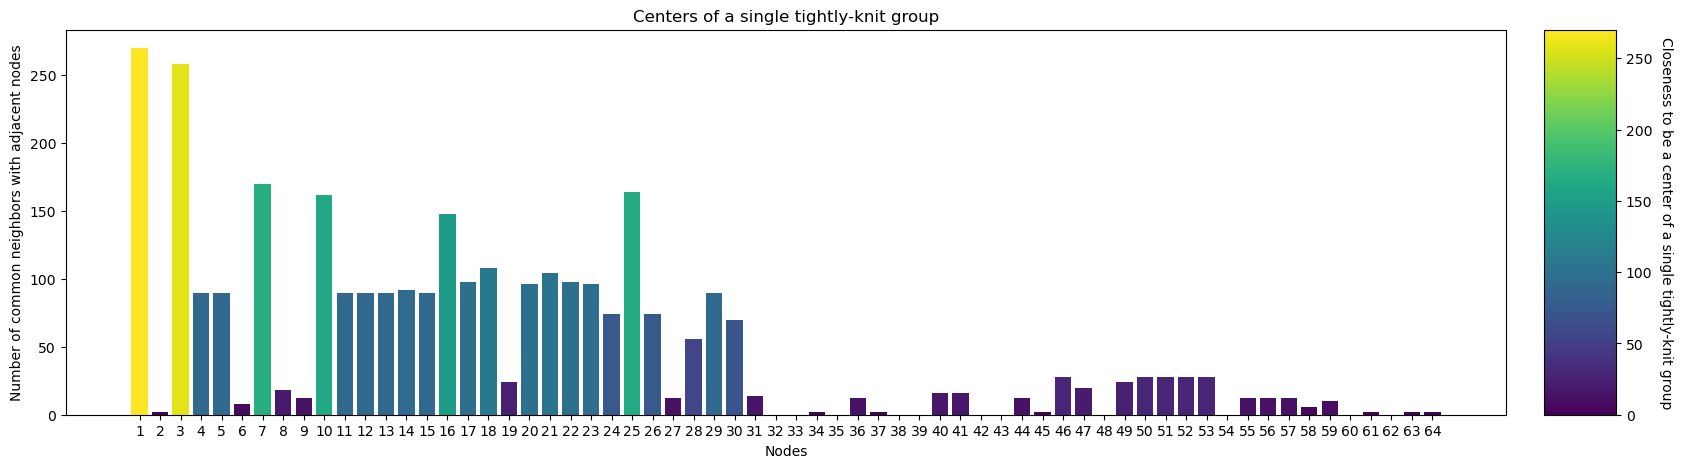

In [27]:

x = sorted(list(G.nodes()))
y = []
for node in x:
    sum_common_neighbors = 0
    for edge, emb in embeddedness_edges.items():
        if node in edge:
            sum_common_neighbors += emb
    y.append(sum_common_neighbors)


fig = plt.figure(figsize=(20,5))
gs = gridspec.GridSpec(1, 2, width_ratios=[20, 1], wspace=0.05)  # Regola width_ratios e wspace

ax_bar = plt.subplot(gs[0])

norm = mcolors.Normalize(min(y), max(y))
cmap = cm.viridis  
colors = cmap(norm(y))

bars = ax_bar.bar(x, y, tick_label=x, color=colors)
ax_bar.set_xlabel('Nodes')
ax_bar.set_ylabel('Number of common neighbors with adjacent nodes')
ax_bar.set_title('Centers of a single tightly-knit group')

ax_cbar = plt.subplot(gs[1])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = plt.colorbar(sm, cax=ax_cbar, orientation='vertical')
cbar.set_label('Closeness to be a center of a single tightly-knit group', rotation=270, labelpad=15)

plt.show()

# Assortativity

C:\Users\Lucrezia\AppData\Local\Temp\ipykernel_16904\2425537850.py:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g--" (-> color='g'). The keyword argument will take precedence.
  plt.plot(x_line, y_line, 'g--', color='black', label='Linear regression')


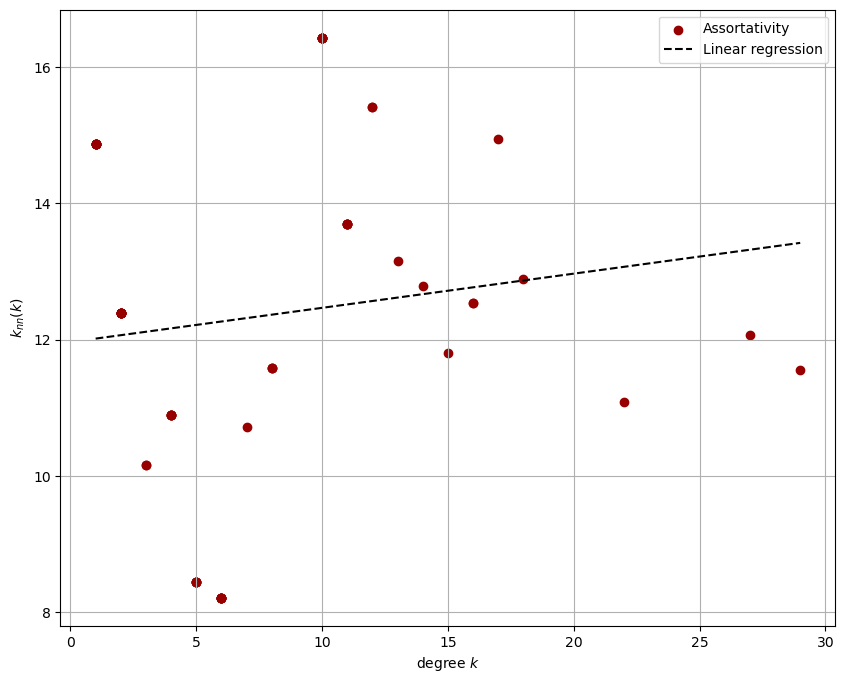

In [28]:
# Assortativity: core-periphey network
# Disassortativity: hub-and-spoke network

# average of each node i's neighbors'degrees

def k_nn_node(G, node):
    deg_node = G.degree(node)
    neighbors = G.neighbors(node)
    deg_neighbors = [G.degree(n) for n in neighbors]

    return sum(deg_neighbors) / deg_node

def k_nn_deg(G, k):
    deg_k_nodes = [node for node in G.nodes if G.degree(node) == k]
    k_nn_nodes = [k_nn_node(G, node) for node in deg_k_nodes]

    return np.mean(k_nn_nodes)

plt.figure(figsize=(10,8))
x = sorted([G.degree(node) for node in G.nodes])
y = [k_nn_deg(G, k) for k in x]
plt.scatter(x,y, color='#980000', label='Assortativity')
plt.xlabel('degree $k$')
plt.ylabel('$k_{nn}(k)$')

# Linear regression
model = LinearRegression()
model.fit(np.array(x).reshape(-1,1), np.array(y).reshape(-1,1))
x_line = np.linspace(min(x), max(x), 100).reshape(-1, 1)
y_line = model.predict(x_line)
plt.plot(x_line, y_line, 'g--', color='black', label='Linear regression')

plt.grid(True)
plt.legend()
plt.show()

In [29]:
print(f'The slope of the fitting line is {round(model.coef_[0][0], 3)}')

The slope of the fitting line is 0.05


Quite positive assortativity means that there is a core-periphery structure, but not as pronounced.

# Centrality measures

## Degree 
Degree of a node: number of neighbors of the node

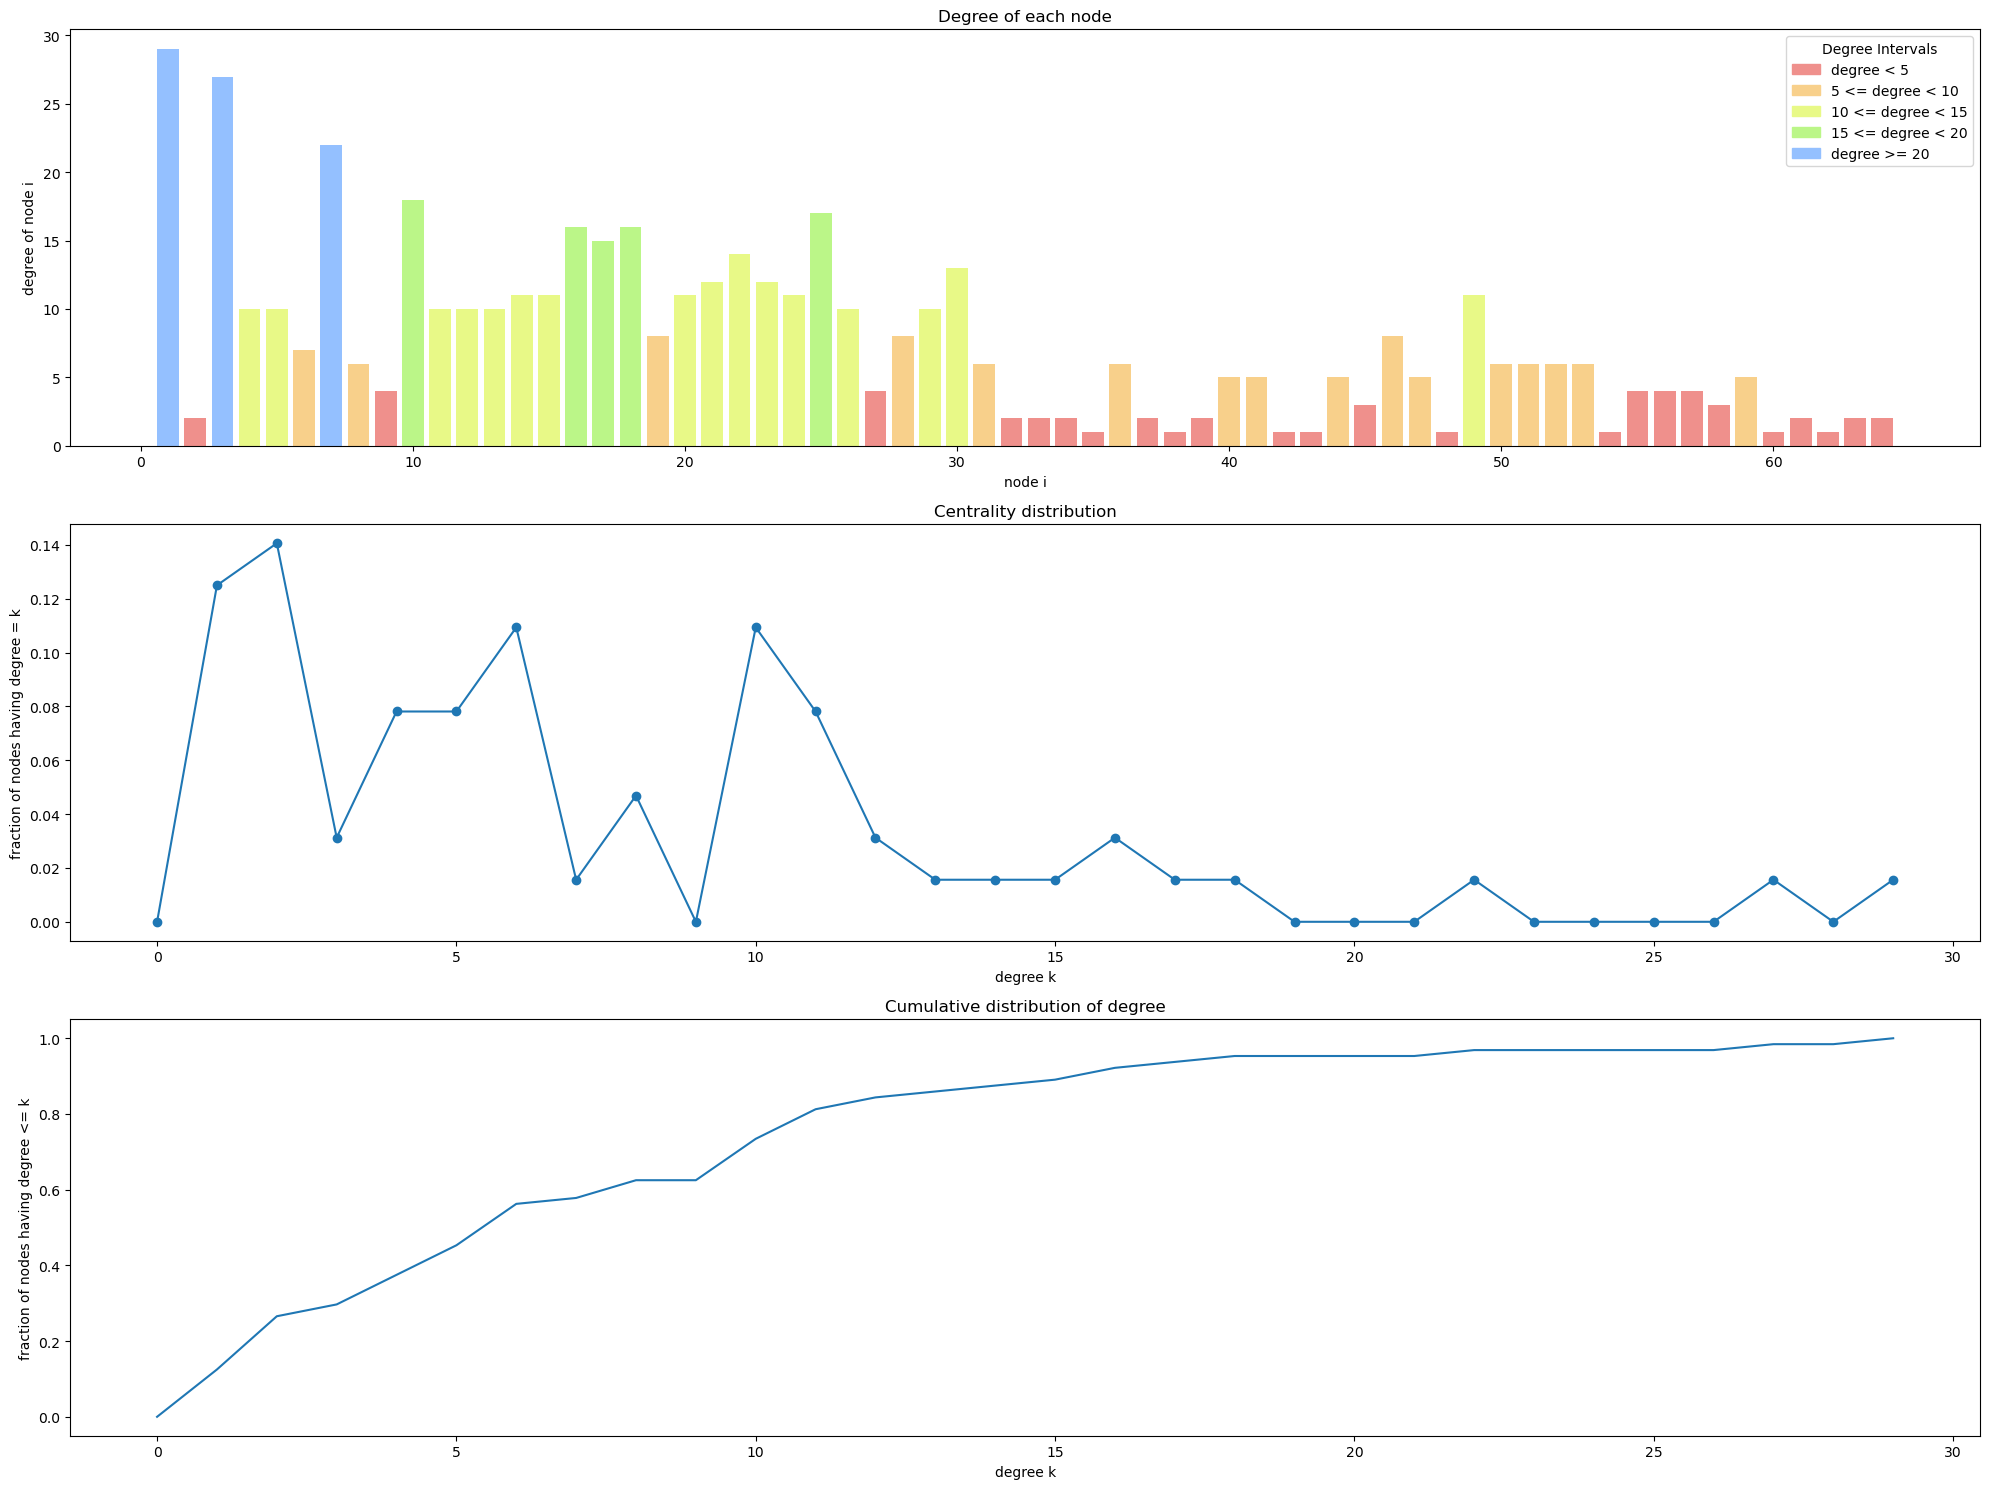

In [30]:
# Degree
degrees = [G.degree(node) for node in G.nodes]
x1 = G.nodes
y1 = degrees
fig, ax = plt.subplots(3,1, figsize=(20,15))
color_map = []
for deg in y1:
    if deg<5:
        color_map.append('#ef908c')
    elif (deg>=5) & (deg<10):
        color_map.append('#f8d08b')
    elif (deg>=10) & (deg<15):
        color_map.append('#e8f987')
    elif (deg>=15) & (deg<20):
        color_map.append('#bbf688')
    else:
        color_map.append('#94c0ff')

ax[0].bar(x1, y1, color=color_map)
ax[0].set_title('Degree of each node')
ax[0].set_xlabel('node i')
ax[0].set_ylabel('degree of node i')
legend_handles = [
    mpatches.Patch(color='#ef908c', label='degree < 5'),
    mpatches.Patch(color='#f8d08b', label='5 <= degree < 10'),
    mpatches.Patch(color='#e8f987', label='10 <= degree < 15'),
    mpatches.Patch(color='#bbf688', label='15 <= degree < 20'),
    mpatches.Patch(color='#94c0ff', label='degree >= 20')
]
ax[0].legend(handles=legend_handles, title="Degree Intervals", loc='upper right')


# Centrality distributions
degree_centrality = nx.degree_histogram(G)
x2 = range(len(degree_centrality))
y2 = degree_centrality
degree_distribution = np.array(y2) / G.number_of_nodes()
ax[1].plot(x2, degree_distribution, 'o-')
ax[1].set_title('Centrality distribution')
ax[1].set_xlabel('degree k')
ax[1].set_ylabel('fraction of nodes having degree = k')


# Cumulative distributions
x3 = range(len(degree_centrality))
y3 = []
for i,dc in enumerate(degree_centrality):
    y3.append(sum(degree_centrality[:i+1]))
y3 = np.array(y3) /max(y3)
ax[2].plot(x3, y3)
ax[2].set_title('Cumulative distribution of degree')
ax[2].set_xlabel('degree k')
ax[2].set_ylabel('fraction of nodes having degree <= k')


plt.tight_layout()
plt.show() 

In [31]:
# Heterogeneity parameter

def heterogeneity_parameter(G):
    degrees = [G.degree(node) for node in G.nodes]
    variance_degree = sum([deg**2 for deg in degrees]) / G.number_of_nodes()
    mean_degree = sum([deg for deg in degrees]) / G.number_of_nodes()
    return variance_degree / mean_degree**2

hp = heterogeneity_parameter(G)
print(f'The heterogeneity parameter of the graph is {hp}')

The heterogeneity parameter of the graph is 1.6588257210113635


The parameter is biger than 1, but not so many. This means that the the distribution is not so heterogeneous. We expect it since the fraction of degrees never exceeds 15% of the entire set of nodes.

## Closeness
A node is the more central the closer it is to the other nodes, on average.

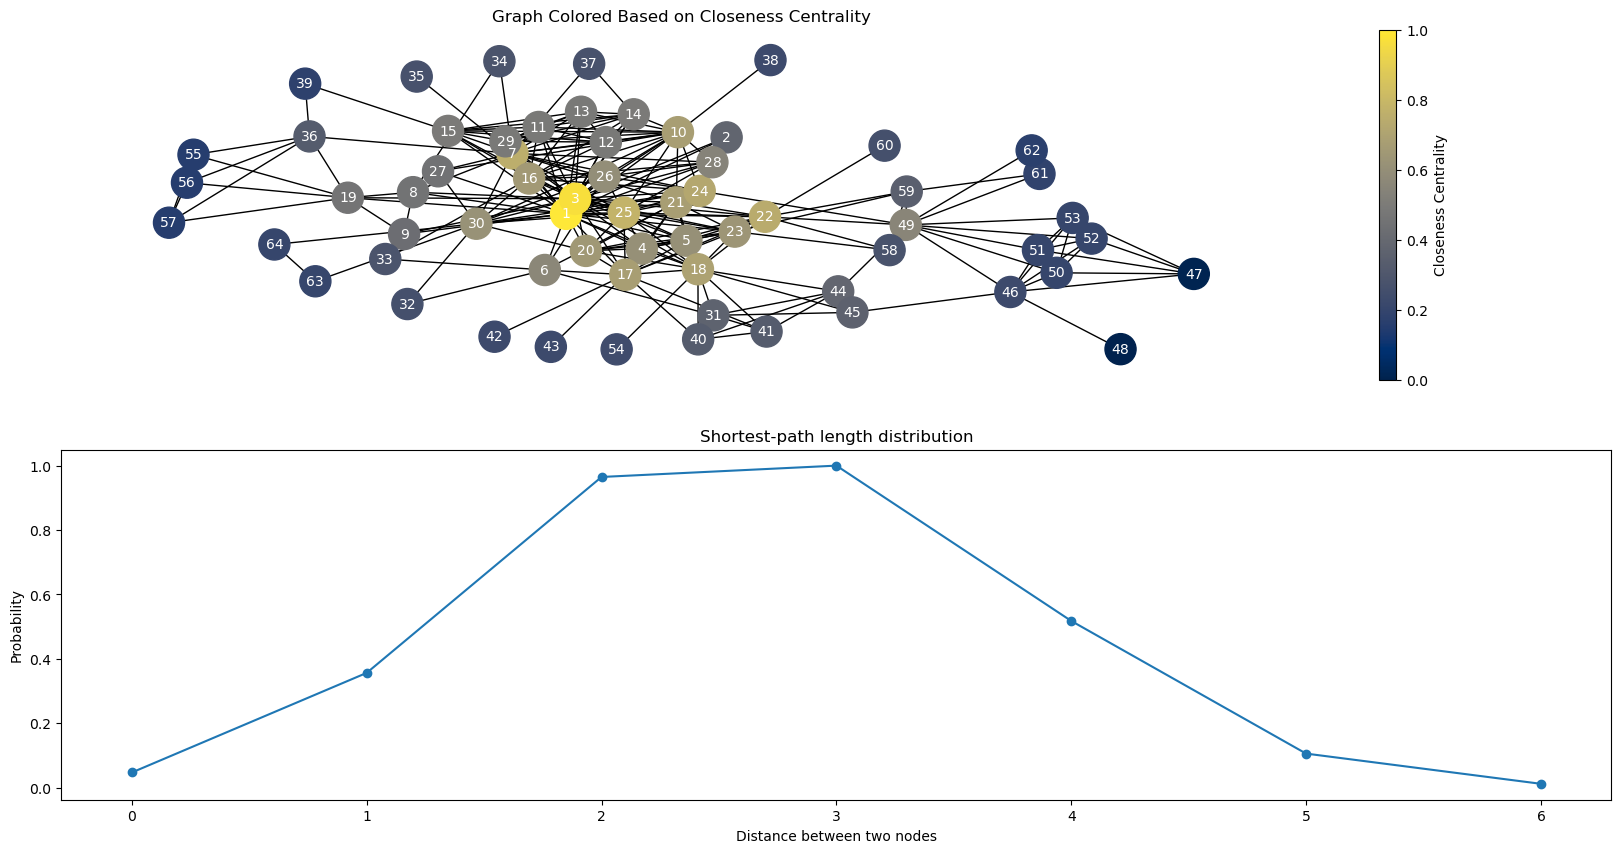

In [32]:
# Closeness

closeness = nx.closeness_centrality(G)
# normalize the betweenness
norm_closeness = np.array(list(closeness.values()))
norm_closeness = (norm_closeness - norm_closeness.min()) / (norm_closeness.max() - norm_closeness.min())

cmap = plt.cm.cividis
colors = [cmap(b) for b in norm_closeness]

fig, ax = plt.subplots(2,1, figsize=(20, 10))
nx.draw(G, pos=pos, node_color=colors, with_labels=True, node_size=500, font_size=10, font_color='white', ax=ax[0])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax[0])
cbar.set_label('Closeness Centrality')
ax[0].set_title('Graph Colored Based on Closeness Centrality')


# Shortest-path length distribution
shortest_path_lenghts = [[nx.shortest_path_length(G, n1, n2) for n1 in G.nodes]for n2 in G.nodes]
distances = sorted(list(set(np.array(shortest_path_lenghts).flatten())))
frequency_distances = [list(np.array(shortest_path_lenghts).flatten()).count(s) for s in distances]
frequency_distances= np.array(frequency_distances) / max(frequency_distances)
ax[1].plot(distances, frequency_distances, 'o-')
ax[1].set_title('Shortest-path length distribution')
ax[1].set_xlabel('Distance between two nodes')
ax[1].set_ylabel('Probability')


plt.show()

## Betweenness
A node is the more central the more often it is crossed by paths.\
Hubs usually have high betweenness, but there can be nodes with high betweenness that are not hubs.

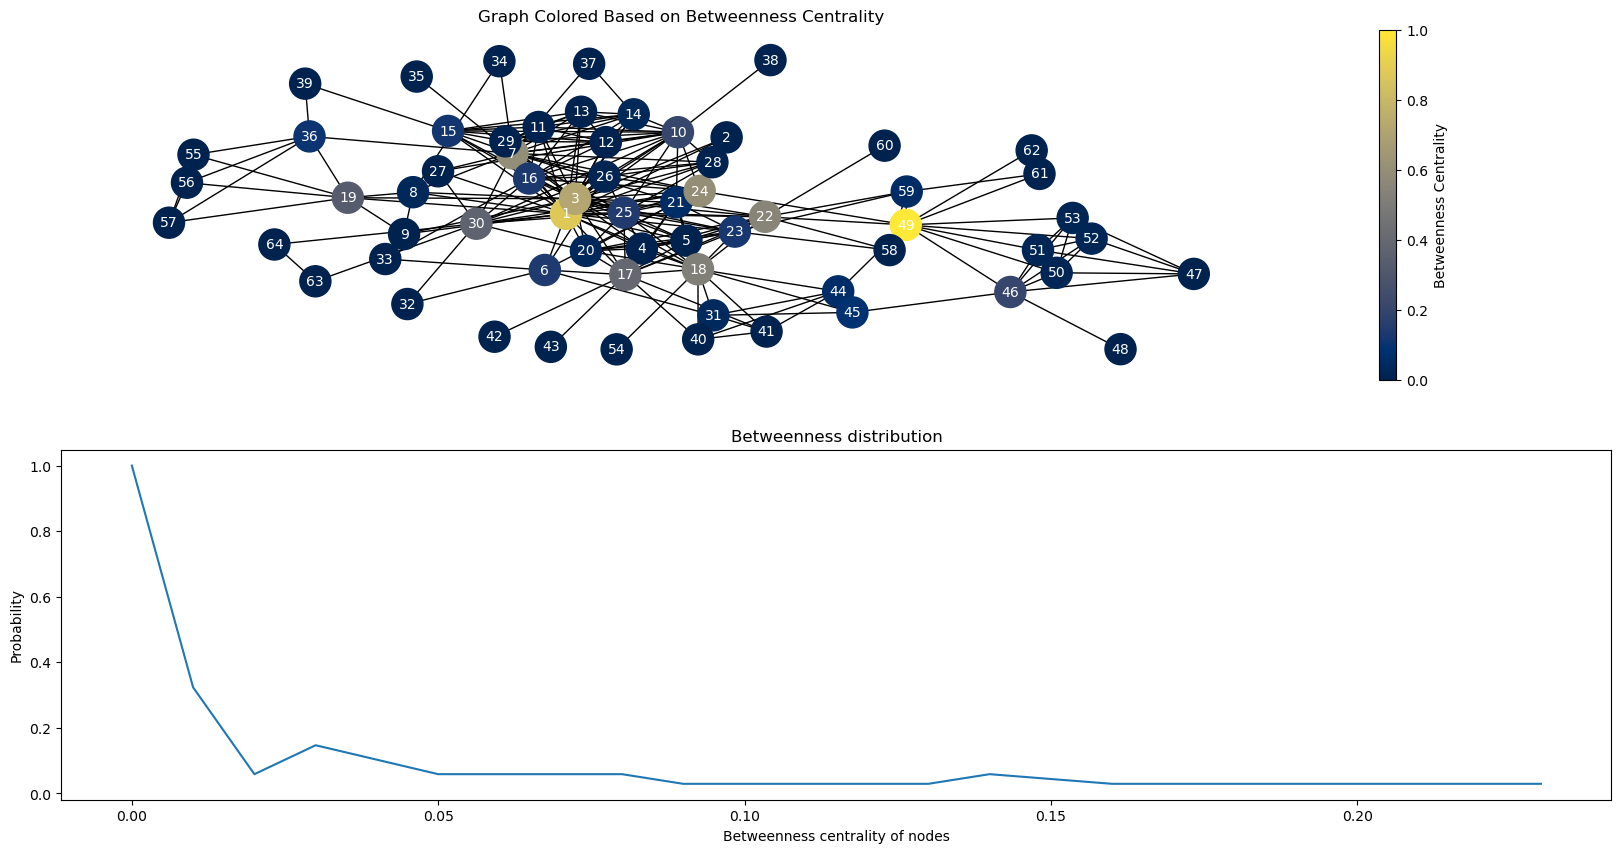

In [33]:
# Betweennes 

betweenness = nx.betweenness_centrality(G)
# normalize the betweenness
norm_betweenness = np.array(list(betweenness.values()))
norm_betweenness = (norm_betweenness - norm_betweenness.min()) / (norm_betweenness.max() - norm_betweenness.min())

cmap = plt.cm.cividis
colors = [cmap(b) for b in norm_betweenness]

fig, ax = plt.subplots(2,1, figsize=(20, 10))

cmap = plt.cm.cividis
colors = [cmap(b) for b in norm_betweenness]
nx.draw(G, pos=pos, node_color=colors, with_labels=True, node_size=500, font_size=10, font_color='white', ax=ax[0])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax[0])
cbar.set_label('Betweenness Centrality')
ax[0].set_title('Graph Colored Based on Betweenness Centrality')


# Betweenness distributions
betweenness_rounded = [round(bet, 2) for bet in betweenness.values()]
betweenness_rounded_dict = dict(zip(G.nodes,betweenness_rounded))
x = sorted(betweenness_rounded_dict.values())
y = [list(betweenness_rounded_dict.values()).count(b) for b in x]
y = np.array(y) /max(y)
ax[1].plot(x,y)
ax[1].set_title('Betweenness distribution')
ax[1].set_xlabel('Betweenness centrality of nodes')
ax[1].set_ylabel('Probability')

plt.show()

It seems that the nodes 1 and 49 are the most important hubs.

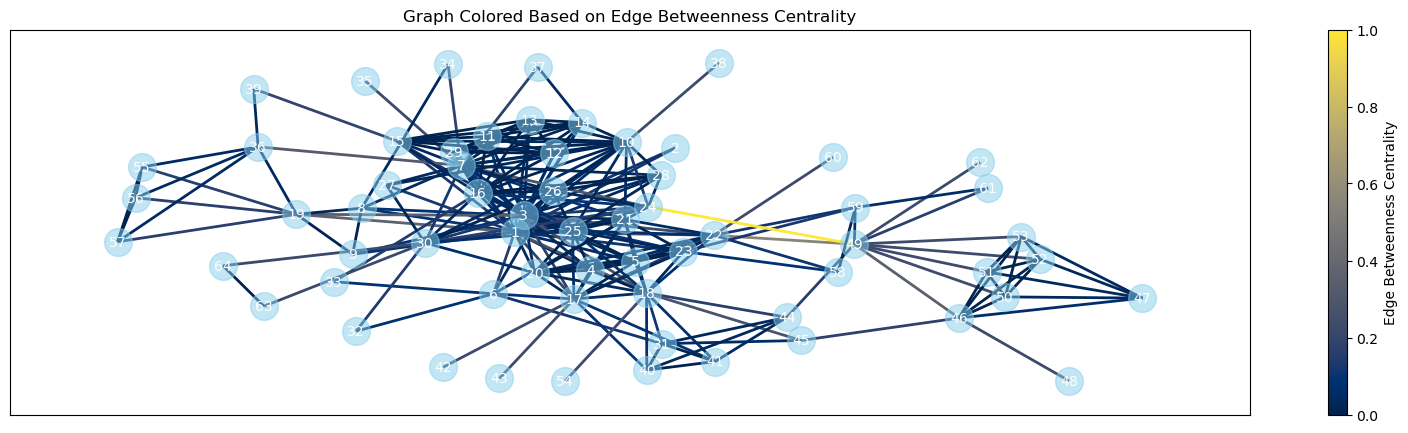

In [34]:

edge_betweenness = nx.edge_betweenness_centrality(G)

edge_values = np.array(list(edge_betweenness.values()))
norm_edge_values = (edge_values - edge_values.min()) / (edge_values.max() - edge_values.min())

fig, ax = plt.subplots(figsize=(20, 5))

cmap = plt.cm.cividis
edge_colors = [cmap(value) for value in norm_edge_values]
nx.draw_networkx_nodes(G, pos, node_color='skyblue', alpha=0.5, node_size=400, ax=ax)
nx.draw_networkx_labels(G, pos, font_size=10, font_color='white', ax=ax)
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, alpha=1, edge_cmap=cmap, width=2, ax=ax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Edge Betweenness Centrality')

ax.set_title('Graph Colored Based on Edge Betweenness Centrality')
plt.show()


# Density - Core Decomposition

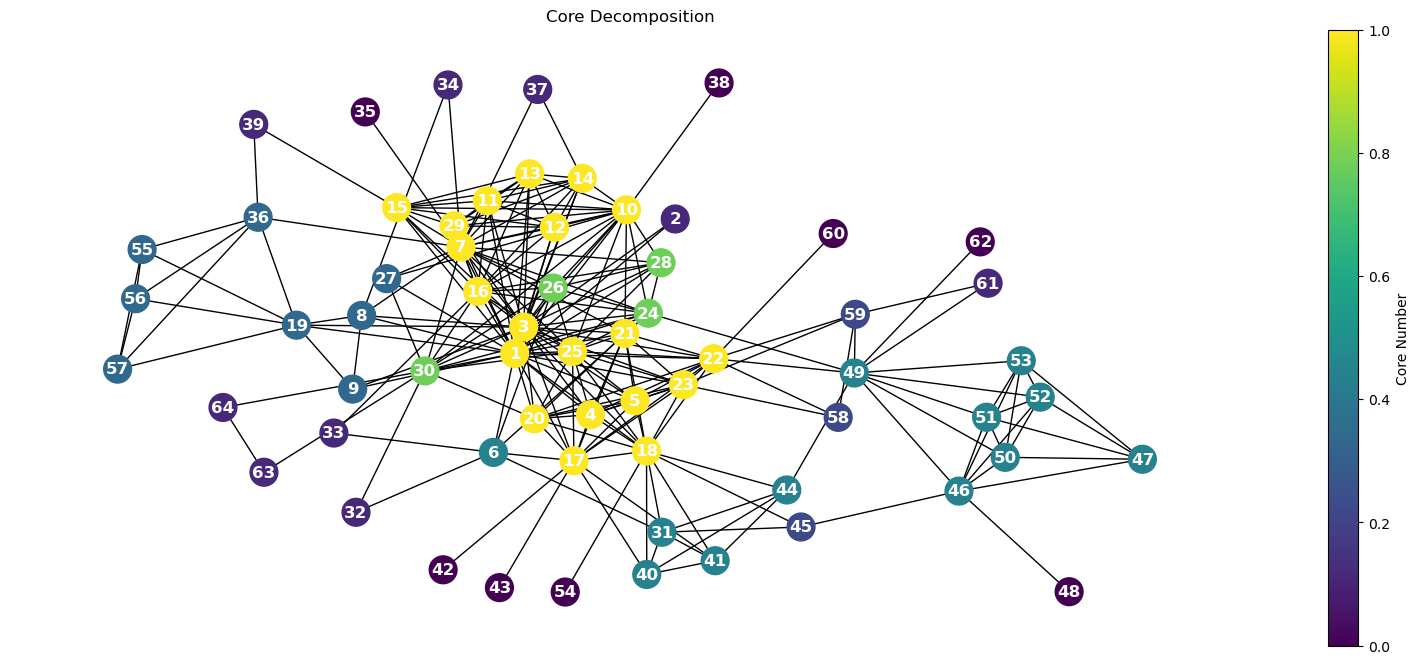

In [35]:
# Core decomposition: procedure to identify denser and denser cores, by removing nodes of progressively higher degree.

core_numbers = nx.core_number(G)
node_colors = [core_numbers[node] for node in G.nodes()]

fig, ax = plt.subplots(figsize=(20,8))
nx.draw(G, pos, with_labels=True, node_color=node_colors, cmap=plt.cm.viridis, node_size=400, font_color='white', font_weight='bold', ax=ax)
plt.title('Core Decomposition')
fig.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.viridis), label='Core Number', ax=ax)
plt.show()


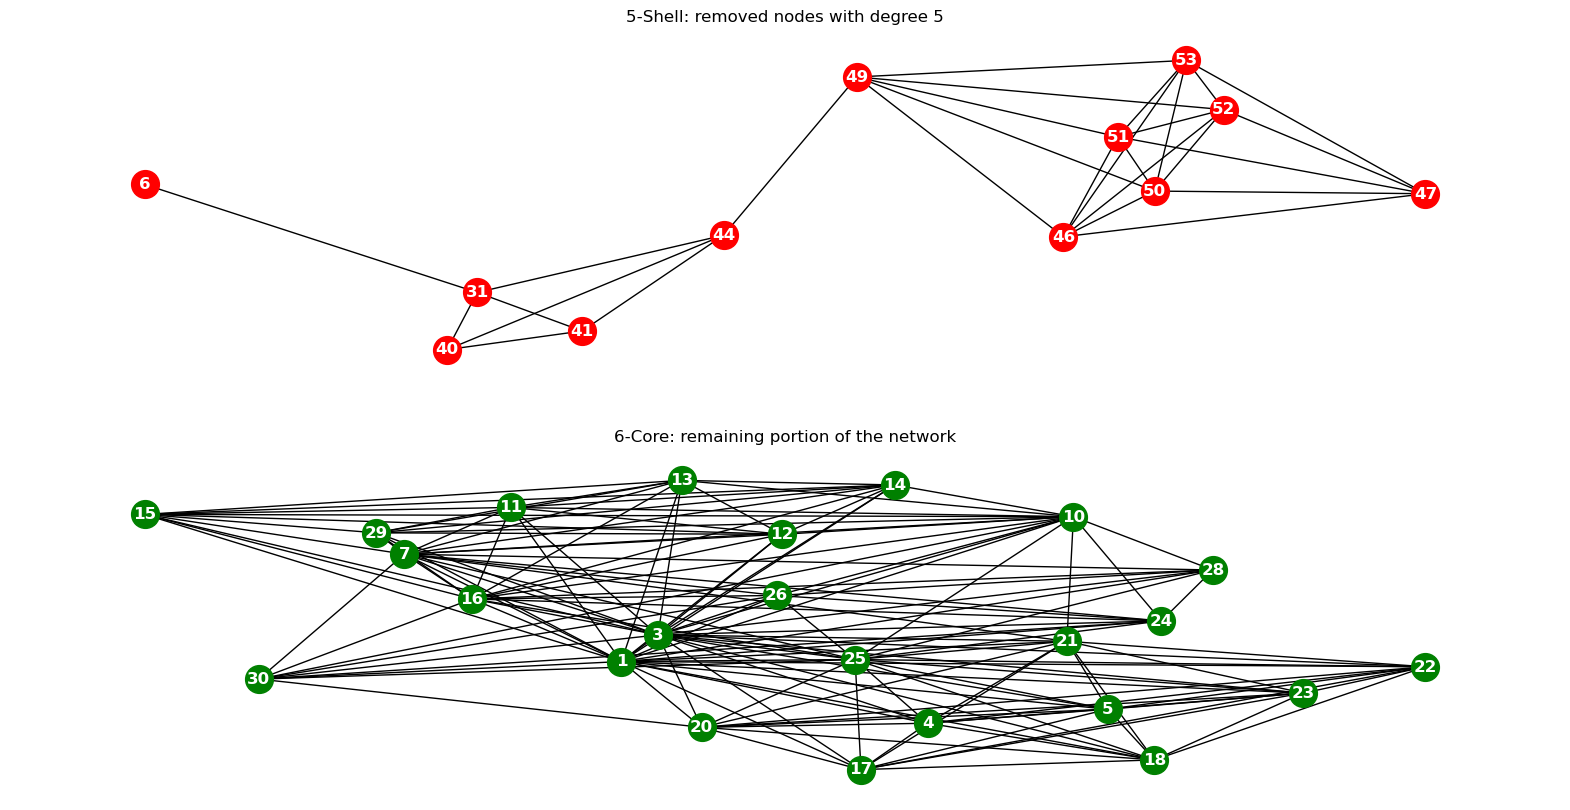

In [36]:
k = 5
fig, ax = plt.subplots(2,1, figsize=(20, 10))

# Visualize k-shell: the set of removed nodes with degree k is the k-th shell
k_shell_subgraph = nx.k_shell(G,k)

nx.draw(k_shell_subgraph, pos, with_labels=True, node_color='red', node_size=400, font_color='white', font_weight='bold', ax=ax[0])
ax[0].set_title(f'{k}-Shell: removed nodes with degree {k}')

# visualization k-core: If we remove all nodes with degree k–1 or lower, the remaining portion of the network is called k-core 
k_core_subgraph = nx.k_core(G, k+1)

nx.draw(k_core_subgraph, pos, with_labels=True, node_color='green', node_size=400, font_color='white', font_weight='bold', ax=ax[1])
ax[1].set_title(f'{k+1}-Core: remaining portion of the network')


plt.tight_layout
plt.show()

In [37]:
def k_core_decomposition(G):
    G_copy = G.copy()
    k_shell = nx.k_shell(G_copy,0)
    k_core = nx.k_core(G_copy,1)
    k_core_decomposition = {0: [set(k_shell), set(k_core)]}

    for k in range(1, max(degrees)):
        if len(k_core) == 0:
            return k_core_decomposition
        else:
            removed_nodes = set()
            while len(nx.k_shell(G_copy,k)) > 0:
                k_shell = nx.k_shell(G_copy,k)
                removed_nodes = removed_nodes | set(k_shell)
                G_copy.remove_nodes_from(k_shell)

            k_core = nx.k_core(G_copy,k+1)
            k_core_decomposition[k] = [k_core_decomposition[k-1][0] | removed_nodes, set(k_core)]


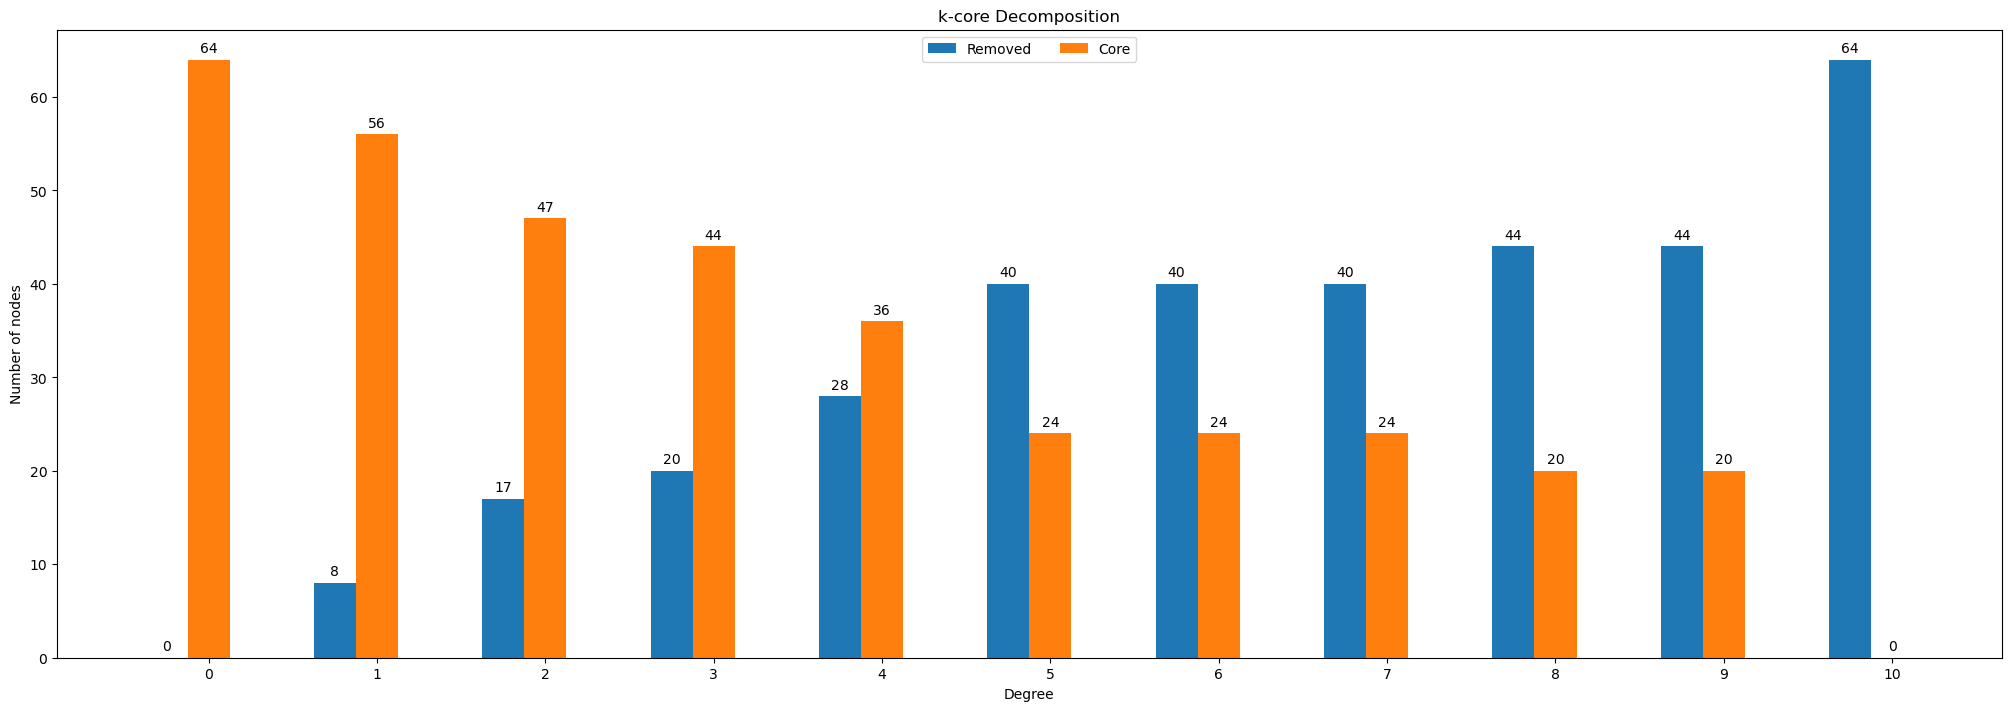

In [38]:
x = list(k_core_decomposition(G).keys())
y = {
    'Removed': [len(dec[0]) for dec in k_core_decomposition(G).values()],
    'Core': [len(dec[1]) for dec in k_core_decomposition(G).values()]
}

width = 0.25
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(20,7))

for attribute, measurement in y.items():
    offset = width * multiplier
    rects = ax.bar(np.array(x) + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Number of nodes')
ax.set_xlabel('Degree')
ax.set_title('k-core Decomposition')
ax.set_xticks(np.array(x) + width, x)
ax.legend(loc='upper center', ncols=3)

plt.show()

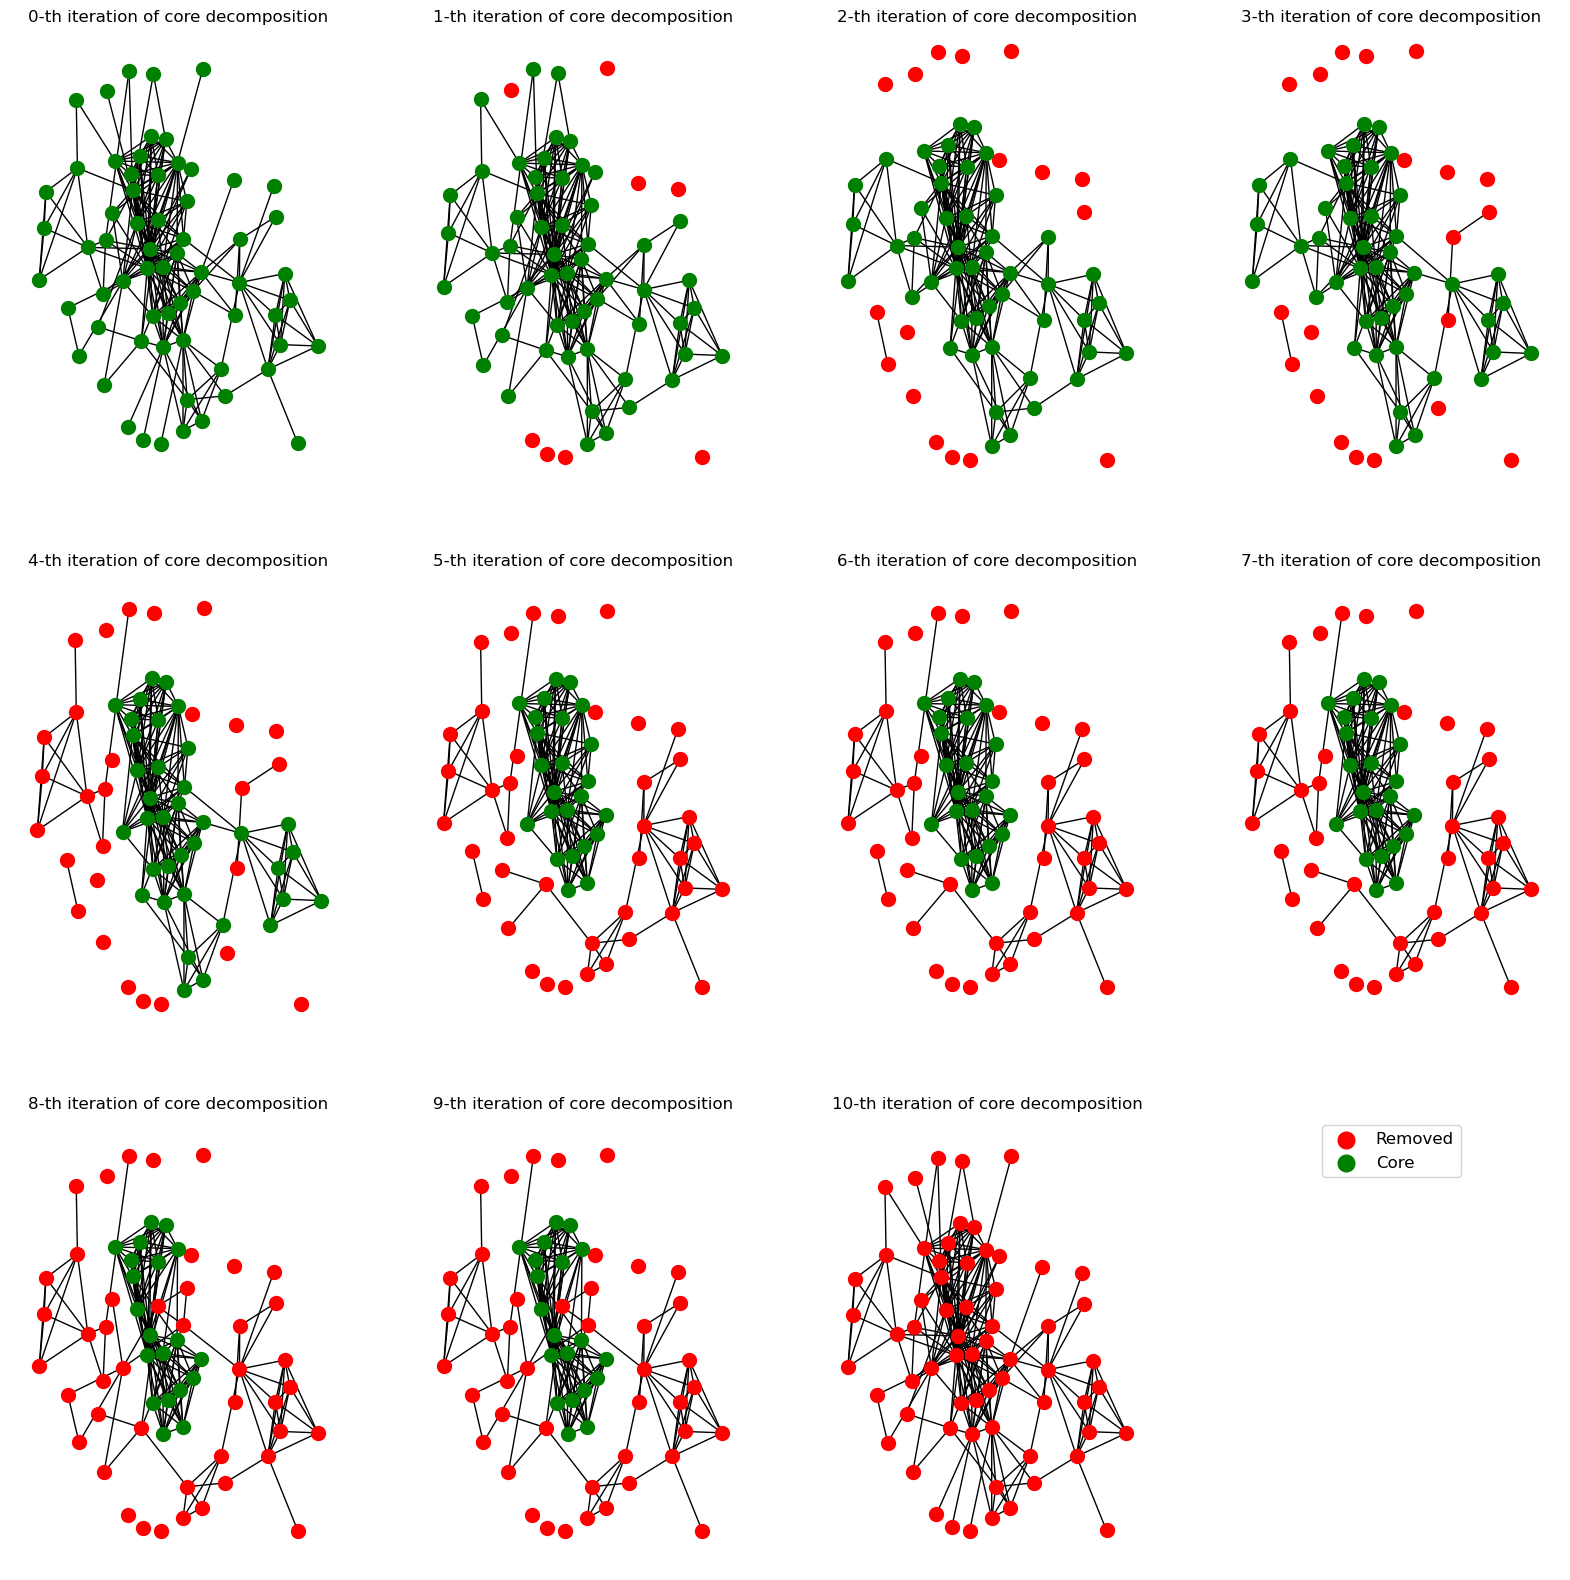

In [39]:
# plt.title(f'{k}-th iteration of core decomposition')
fig, ax = plt.subplots(3,4, figsize=(20, 20))
ax = ax.flatten()

for k, node in k_core_decomposition(G).items():
    removed = G.subgraph(node[0])
    core = G.subgraph(node[1])
    # print(ax[k])

    nx.draw(removed, pos, with_labels=False, node_color='red', node_size=100, ax=ax[k])
    nx.draw(core, pos, with_labels=False, node_color='green', node_size=100, ax=ax[k])
    ax[k].set_title(f'{k}-th iteration of core decomposition')

plt.scatter([], [], c='red', label='Removed')
plt.scatter([], [], c='green', label='Core')
ax[-1].legend(loc='upper center', fontsize='large', markerscale=2)
ax[-1].axis('off')
plt.tight_layout
plt.show()

# Community detection

## Kernigham-Lin algorithm
It divides in two equal size subgraph and compute the cut size. Recompute it after swapping a pair of nodes. If the cut size decreases this pair of nodes is locked.

In [40]:
# minimum cut bisection: returns a pair of sets of nodes
partition = nx.community.kernighan_lin_bisection(G)
print(f'{len(partition)} communities, since it is a bisection')

2 communities, since it is a bisection


Cut Size: 46


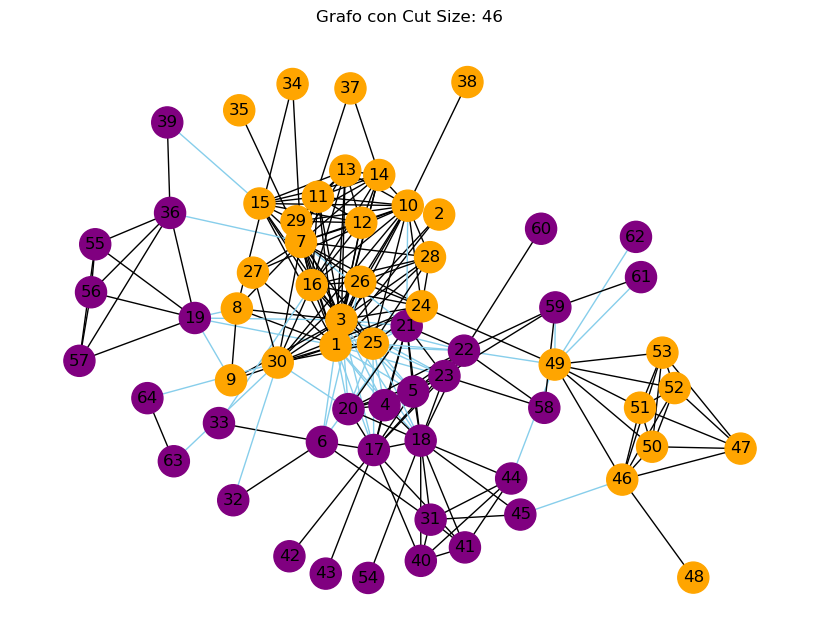

In [41]:
partition = nx.community.kernighan_lin_bisection(G)

def calculate_cut_size(G, partition):
    subset1, subset2 = partition
    cut_size = 0
    for e in G.edges:
        if (e[0] in subset1 and e[1] in subset2) or (e[0] in subset2 and e[1] in subset1):
            cut_size += 1
    return cut_size

cut_size = calculate_cut_size(G, partition)
print(f"Cut Size: {cut_size}")


colors = ['orange' if node in partition[0] else 'purple' for node in G.nodes()]
edge_colors = ['skyblue' if (u in partition[0] and v in partition[1]) or (u in partition[1] and v in partition[0]) else 'black' for u, v in G.edges()]

plt.figure(figsize=(8, 6))
nx.draw(G, pos, node_color=colors, edge_color=edge_colors, with_labels=True, node_size=500)
plt.title(f'Grafo con Cut Size: {cut_size}')
plt.show()


In [42]:
# weights_colors

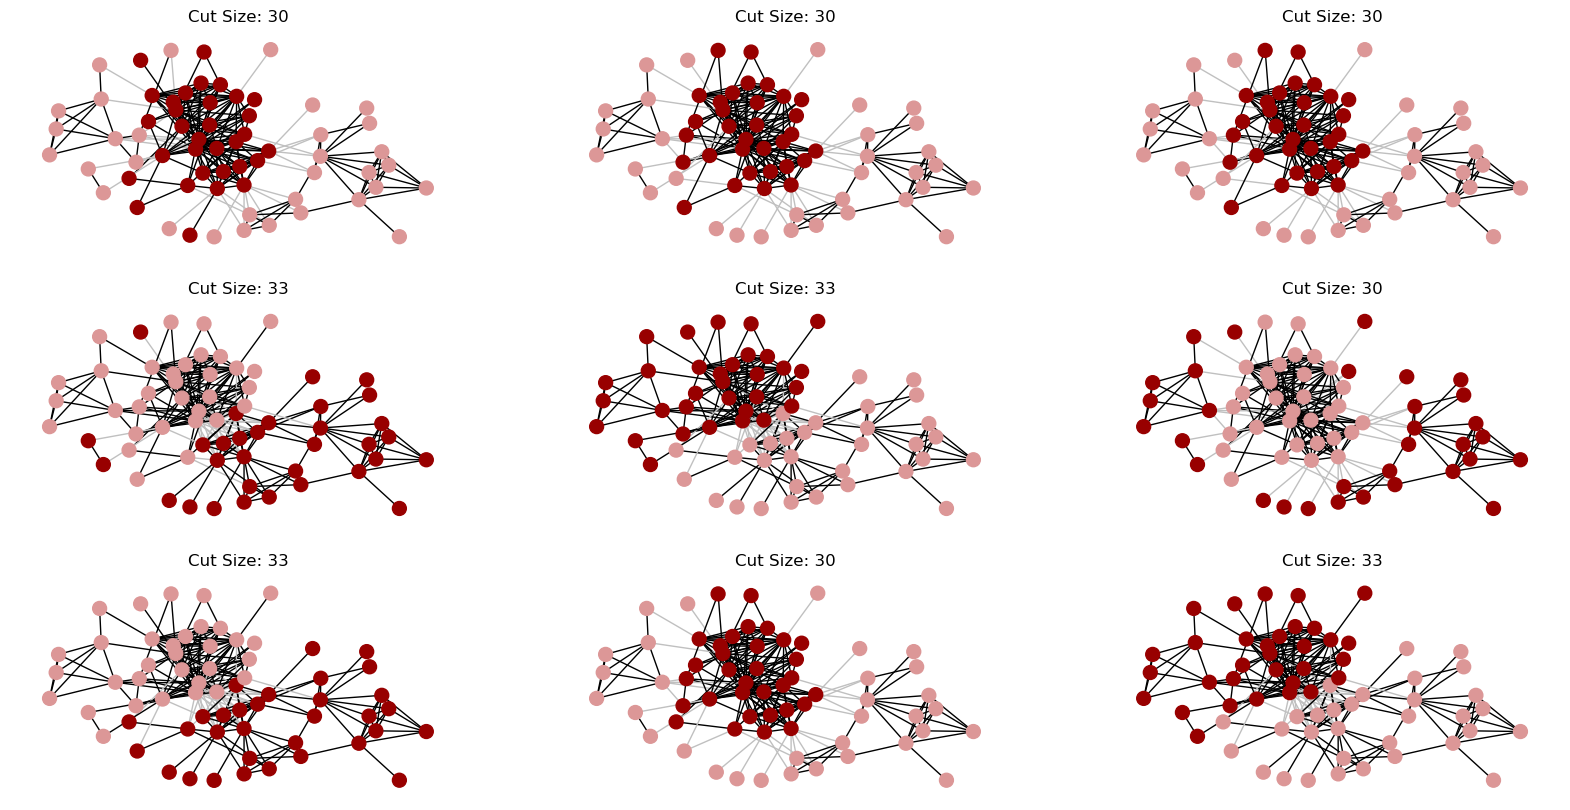

In [43]:
fig, ax = plt.subplots(3,3,figsize=(20,10))
ax = ax.flatten()

best_cut_size = G.number_of_edges()
for i in range(9):
    kl_partition = nx.community.kernighan_lin_bisection(G)

    cut_size = calculate_cut_size(G, kl_partition)
    if cut_size < best_cut_size:
        best_cut_size = cut_size
        best_kl_partition = kl_partition

    colors = ['#DC9797' if node in kl_partition[0] else '#980000' for node in G.nodes()]
    edge_colors = ['#C0C0C0' if (u in kl_partition[0] and v in kl_partition[1]) or (u in kl_partition[1] and v in kl_partition[0]) else 'black' for u, v in G.edges()]

    nx.draw(G, pos, node_color=colors, edge_color=edge_colors, with_labels=False, node_size=100, ax=ax[i])
    ax[i].set_title(f'Cut Size: {cut_size}')

plt.show()


In [44]:
print(f'The minimum cut size in {best_cut_size}')

The minimum cut size in 30


Now, perform recursively the algorithm, bisecting the communities found.

In [45]:
def kernighan_lin_partition(G):
    partitions = [tuple([set(n for n in G.nodes)])]

    # while len(partitions[-1]) < G.number_of_nodes():
    while len(partitions[-1]) < 6:
        for p in partitions[-1]:
            list_bisections = []

            if len(p) == 1:
                list_bisections.append(p)

            if len(p) != 1:
                nodes = list(p)
                edges = [e for e in G.edges if (e[0] in nodes) and (e[1] in nodes)]
                P = nx.Graph()
                P.add_nodes_from(nodes)
                P.add_edges_from(edges)
                
                bisection = nx.community.kernighan_lin_bisection(P)
                list_bisections.append(bisection[0])
                list_bisections.append(bisection[1])

            partitions.append(tuple(list_bisections))

    return partitions

In [46]:
# kernighan_lin_partition(G)
# It takes too much time 

## Girvan-Newman algorithm
Remove the link with largest betweenness, recalculate the betweenness of the remaining links. The algorithm stops when all links are removed and the nodes are isolated

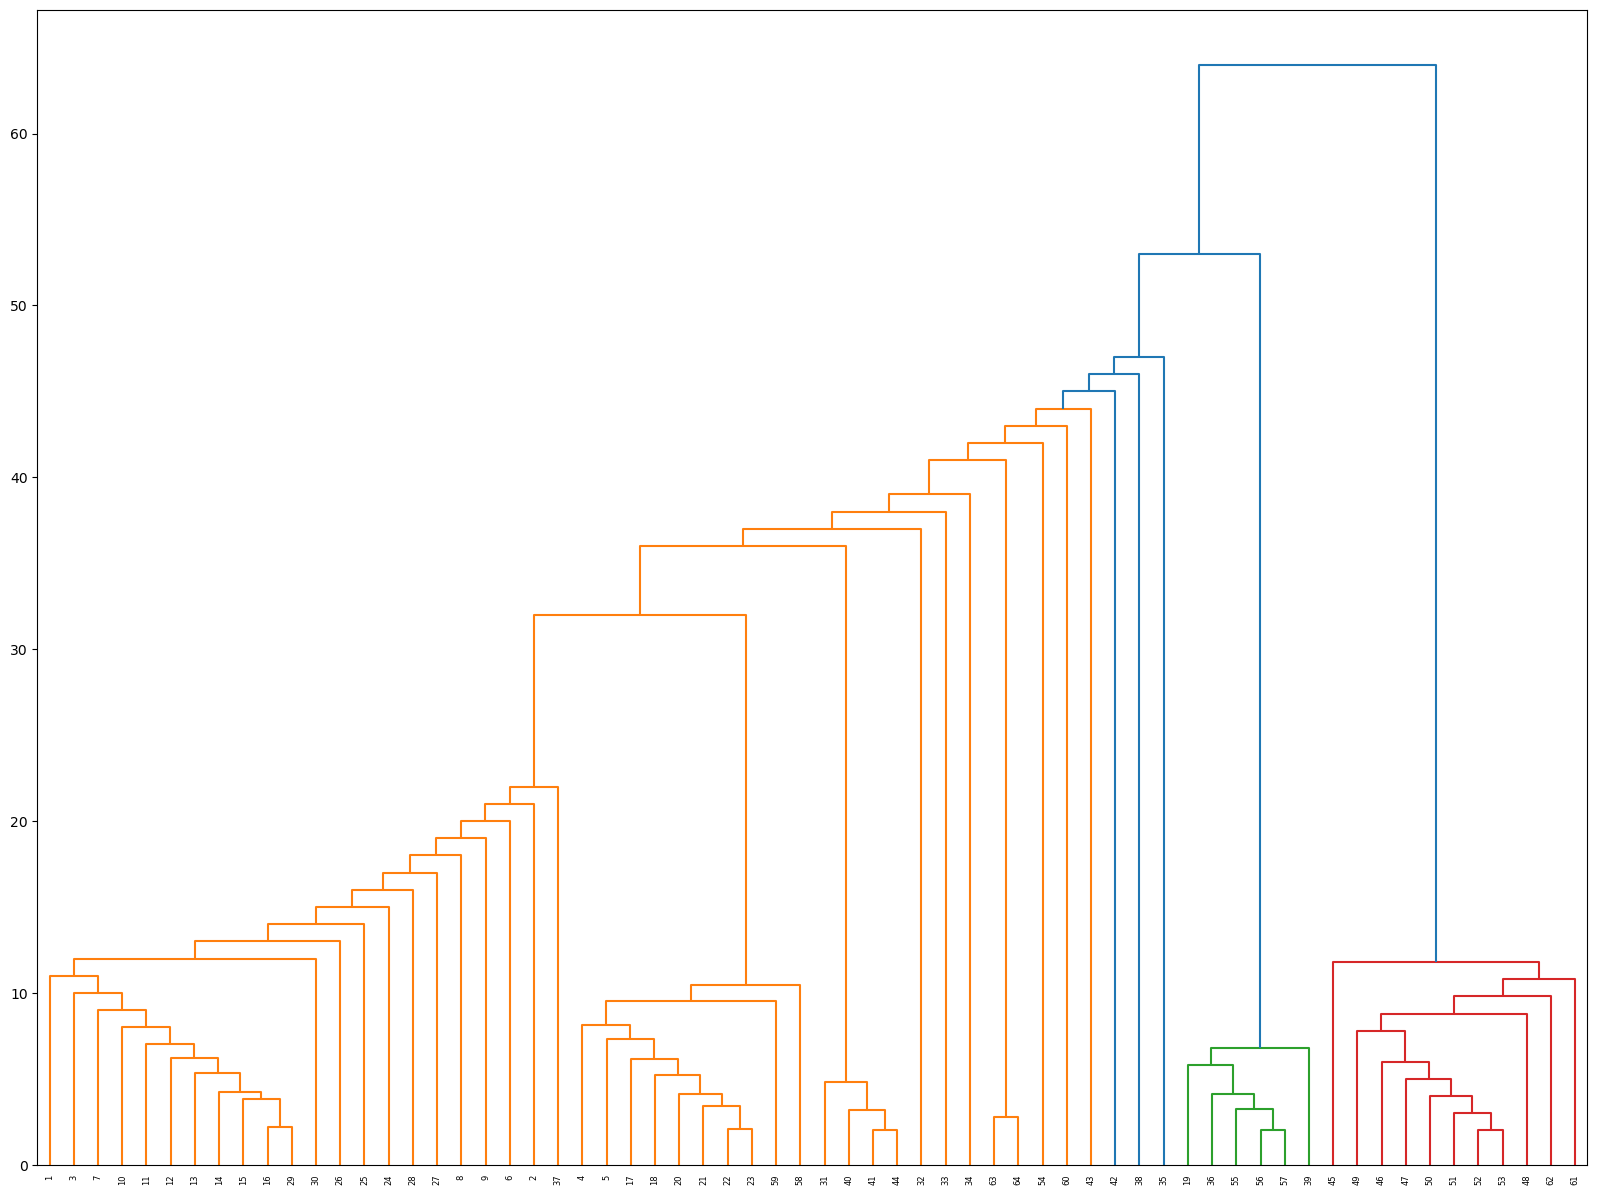

In [47]:
# get simulated Graph() and Girvan-Newman communities list
communities = list(nx.community.girvan_newman(G))

# building initial dict of node_id to each possible subset:
node_id = 0
init_node2community_dict = {node_id: communities[0][0].union(communities[0][1])}
for comm in communities:
    for subset in list(comm):
        if subset not in init_node2community_dict.values():
            node_id += 1
            init_node2community_dict[node_id] = subset

# turning this dictionary to the desired format in @mdml's answer
node_id_to_children = {e: [] for e in init_node2community_dict.keys()}
for node_id1, node_id2 in combinations(init_node2community_dict.keys(), 2):
    for node_id_parent, group in init_node2community_dict.items():
        if len(init_node2community_dict[node_id1].intersection(init_node2community_dict[node_id2])) == 0 and group == init_node2community_dict[node_id1].union(init_node2community_dict[node_id2]):
            node_id_to_children[node_id_parent].append(node_id1)
            node_id_to_children[node_id_parent].append(node_id2)

# also recording node_labels dict for the correct label for dendrogram leaves
node_labels = dict()
for node_id, group in init_node2community_dict.items():
    if len(group) == 1:
        node_labels[node_id] = list(group)[0]
    else:
        node_labels[node_id] = ''

# also needing a subset to rank dict to later know within all k-length merges which came first
subset_rank_dict = dict()
rank = 0
for e in communities[::-1]:
    for p in list(e):
        if tuple(p) not in subset_rank_dict:
            subset_rank_dict[tuple(sorted(p))] = rank
            rank += 1
subset_rank_dict[tuple(sorted(chain.from_iterable(communities[-1])))] = rank

# my function to get a merge height so that it is unique (probably not that efficient)
def get_merge_height(sub):
    sub_tuple = tuple(sorted([node_labels[i] for i in sub]))
    n = len(sub_tuple)
    other_same_len_merges = {k: v for k, v in subset_rank_dict.items() if len(k) == n}
    min_rank, max_rank = min(other_same_len_merges.values()), max(other_same_len_merges.values())
    range = (max_rank-min_rank) if max_rank > min_rank else 1
    return float(len(sub)) + 0.8 * (subset_rank_dict[sub_tuple] - min_rank) / range

# G is slightly modified:
G_modified  = nx.DiGraph(node_id_to_children)
nodes       = G_modified.nodes()
leaves      = set( n for n in nodes if G_modified.out_degree(n) == 0 )
inner_nodes = [ n for n in nodes if G_modified.out_degree(n) > 0 ]

# Compute the size of each subtree
subtree = dict( (n, [n]) for n in leaves )
for u in inner_nodes:
    children = set()
    node_list = list(node_id_to_children[u])
    while len(node_list) > 0:
        v = node_list.pop(0)
        children.add( v )
        node_list += node_id_to_children[v]
    subtree[u] = sorted(children & leaves)

inner_nodes.sort(key=lambda n: len(subtree[n])) # <-- order inner nodes ascending by subtree size, root is last

# Construct the linkage matrix
leaves = sorted(leaves)
index  = dict( (tuple([n]), i) for i, n in enumerate(leaves) )
Z = []
k = len(leaves)
for i, n in enumerate(inner_nodes):
    children = node_id_to_children[n]
    x = children[0]
    for y in children[1:]:
        z = tuple(sorted(subtree[x] + subtree[y]))
        i, j = index[tuple(sorted(subtree[x]))], index[tuple(sorted(subtree[y]))]
        Z.append([i, j, get_merge_height(subtree[n]), len(z)]) # <-- float is required by the dendrogram function
        index[z] = k
        subtree[z] = list(z)
        x = z
        k += 1

# dendrogram
plt.figure(figsize=(20,15))
dendrogram(Z, labels=[node_labels[node_id] for node_id in leaves])
plt.show()

## Modularity
Compute the quality of the partition given by Girvan-Newman

In [48]:
list_modularities = []
list_nr_clusters = []
max_modularity = 0
for n in range(1,64):
    for p in list(nx.community.girvan_newman(G)):
        if len(p) == n:
            partition_gn = p
            modularity = nx.community.quality.modularity(G,partition_gn)
            list_modularities.append(modularity)
            list_nr_clusters.append(n)
            if modularity > max_modularity:
                max_modularity = modularity
                max_n = n
                best_partition = partition_gn
# about 2 minutes

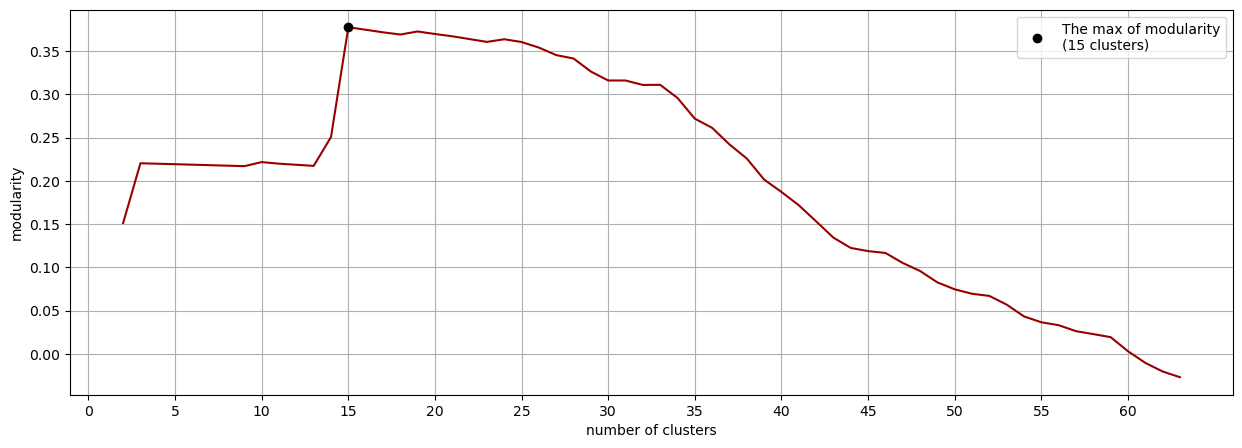

In [49]:
plt.figure(figsize=(15,5))
plt.plot(list_nr_clusters, list_modularities, color='#980000')
plt.plot(max_n, max_modularity, 'o', color='black', label=f'The max of modularity\n({max_n} clusters)')
plt.xlabel('number of clusters')
plt.xticks(np.linspace(0,60,13))
plt.ylabel('modularity')
plt.legend()
plt.grid(True)
plt.show()

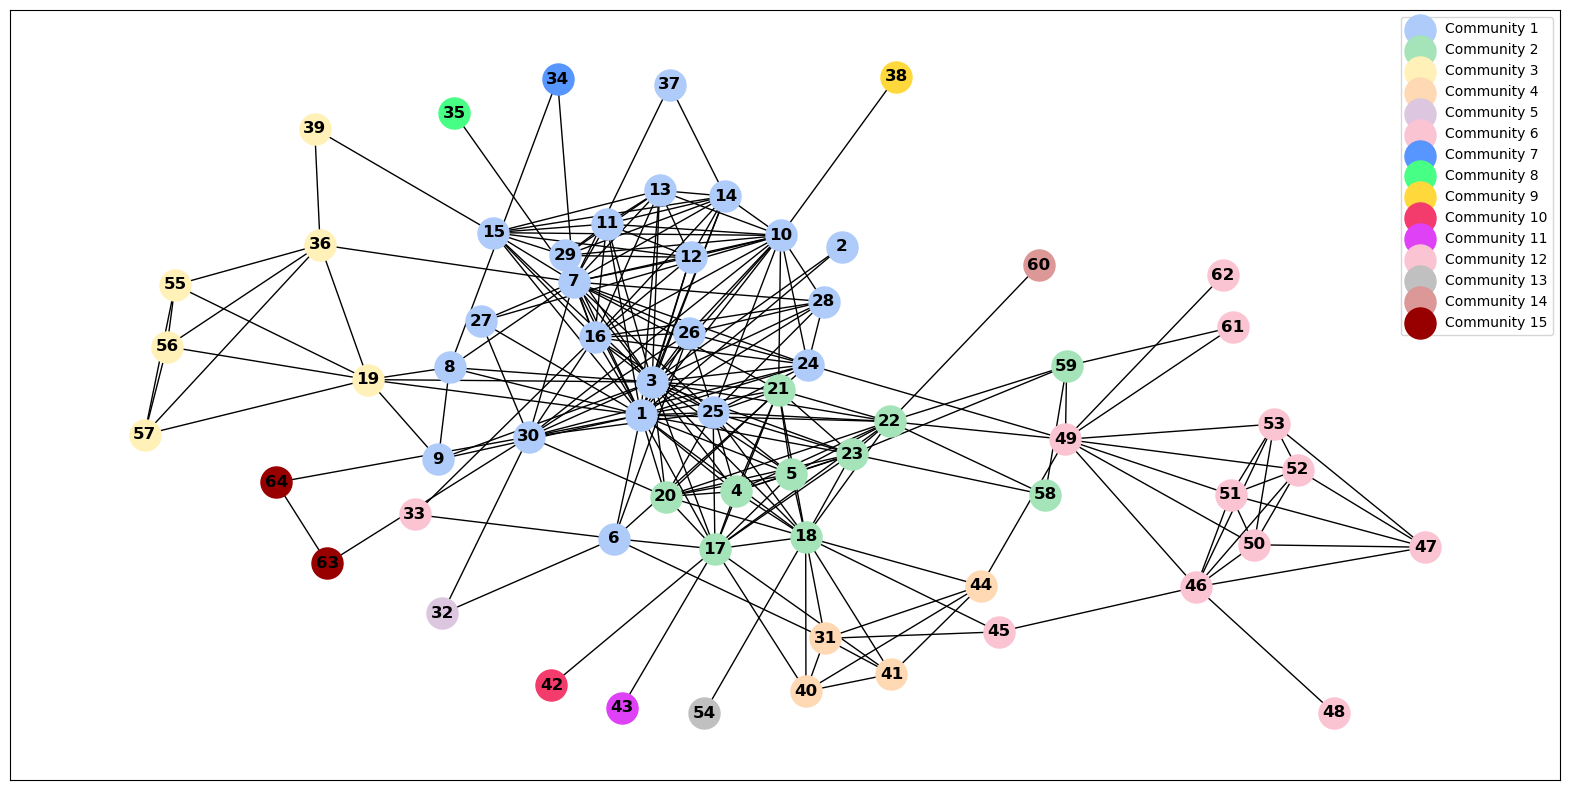

In [50]:
plt.figure(figsize=(20,10))
colors = ['#AECBFA', '#A4E4B8', '#FFF1B8', '#FFD9B3', '#DCC6E0', '#FBC4D3',
          '#5795FF', '#47FF85', '#FFD93C', '#F33B6C', '#DF41F7', '#FBC4D3',
          '#C0C0C0', '#DC9797', '#980000']
for p,c,i in zip(best_partition, colors, range(max_n)):
    nx.draw_networkx_nodes(G, pos, nodelist=list(p), node_size=500, node_color=colors[i], label=f'Community {i+1}')
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')
plt.legend()
plt.show()


## Newman's greedy algorithm

In [51]:
# returns the maximum modularity partition
newman_partition = nx.community.greedy_modularity_communities(G)
print(f'The Newman’s greedy algorithm generates {len(newman_partition)} partitions')


The Newman’s greedy algorithm generates 6 partitions


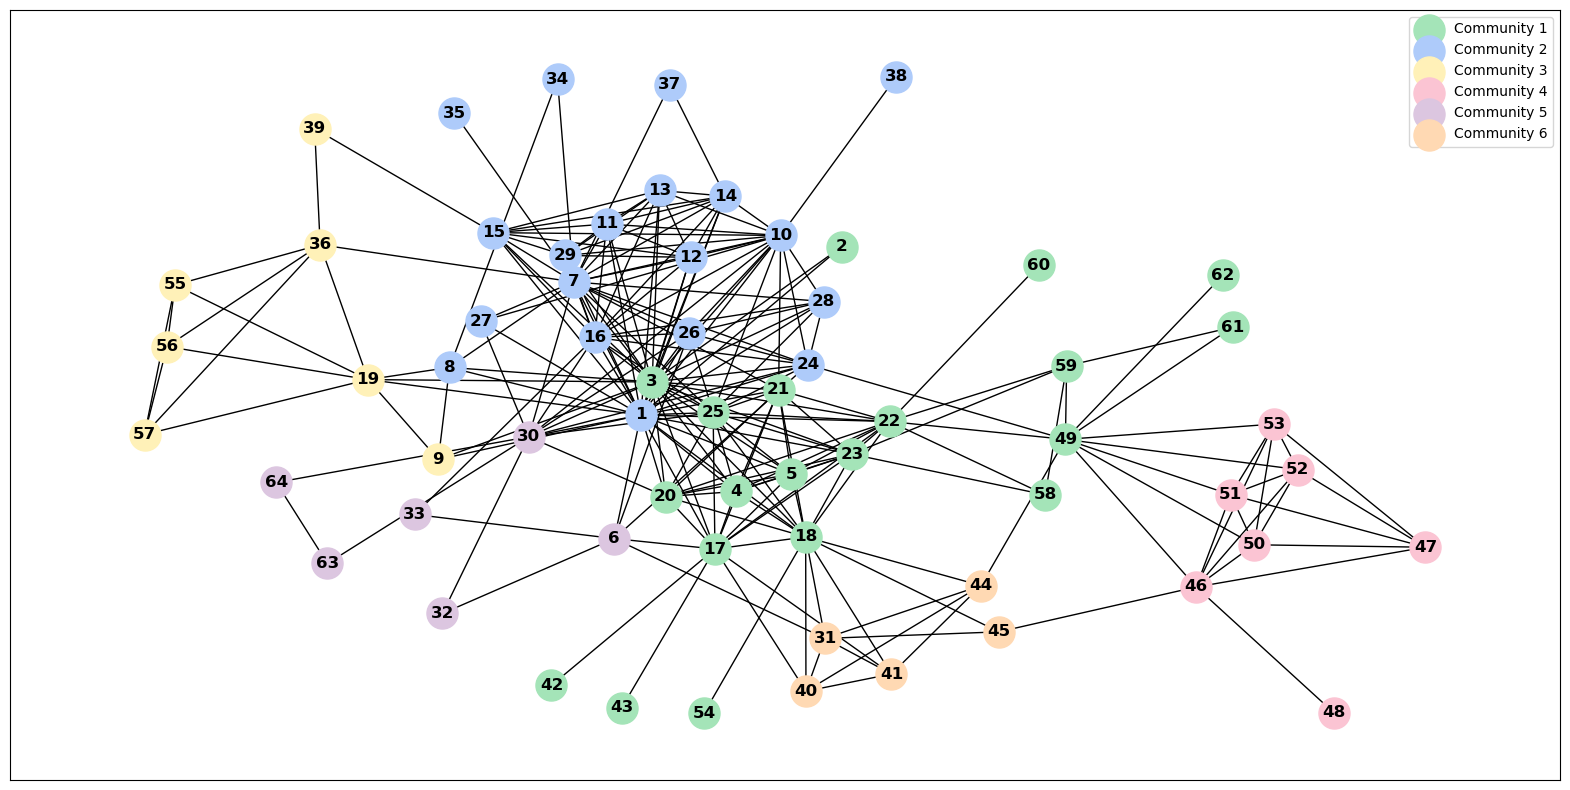

In [52]:
colors = ['#A4E4B8', '#AECBFA', '#FFF1B8', '#FBC4D3', '#DCC6E0', '#FFD9B3']

plt.figure(figsize=(20,10))

for p,c,i in zip(newman_partition, colors, range(len(newman_partition))):
    nx.draw_networkx_nodes(G, pos, nodelist=list(p), node_size=500, node_color=colors[i], label=f'Community {i+1}')
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')
plt.legend()
plt.show()

## Louvain algorithm

In [53]:
louvain_partitions = nx.community.louvain_communities(G)
print(f'The Louvain algorithm provides {len(louvain_partitions)} clusters')

The Louvain algorithm provides 5 clusters


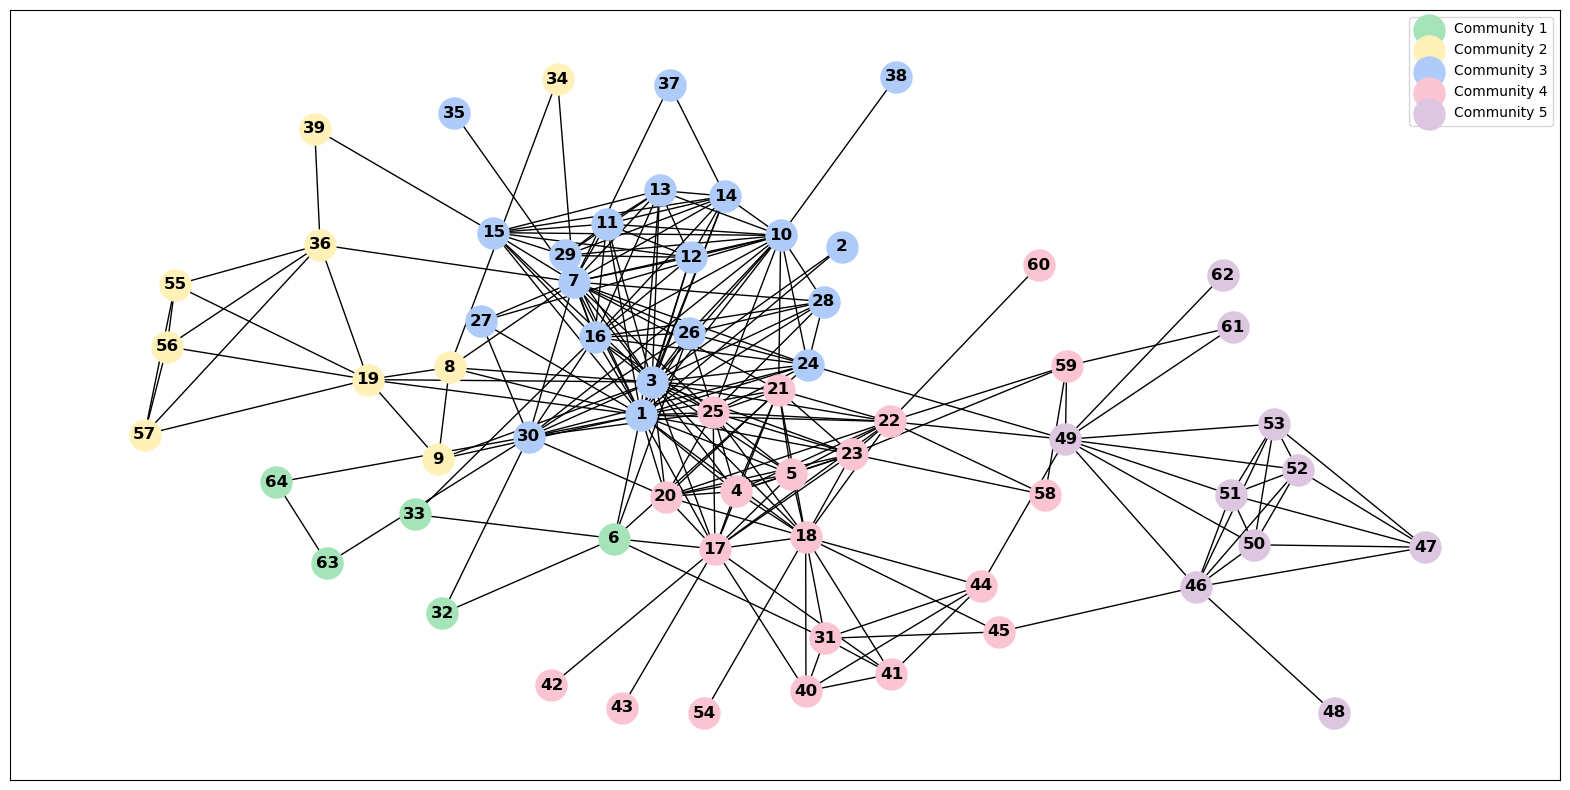

In [54]:
colors = ['#A4E4B8', '#FFF1B8',  '#AECBFA', '#FBC4D3', '#DCC6E0']

plt.figure(figsize=(20,10))

for p,c,i in zip(louvain_partitions, colors, range(len(louvain_partitions))):
    nx.draw_networkx_nodes(G, pos, nodelist=list(p), node_size=500, node_color=colors[i], label=f'Community {i+1}')
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')
plt.legend()
plt.show()

## Label propagation algorithm

In [55]:
lpa_partition = list(nx.community.asyn_lpa_communities(G))
print(f'The label propagation algorithm provides {len(lpa_partition)} clusters')

The label propagation algorithm provides 6 clusters


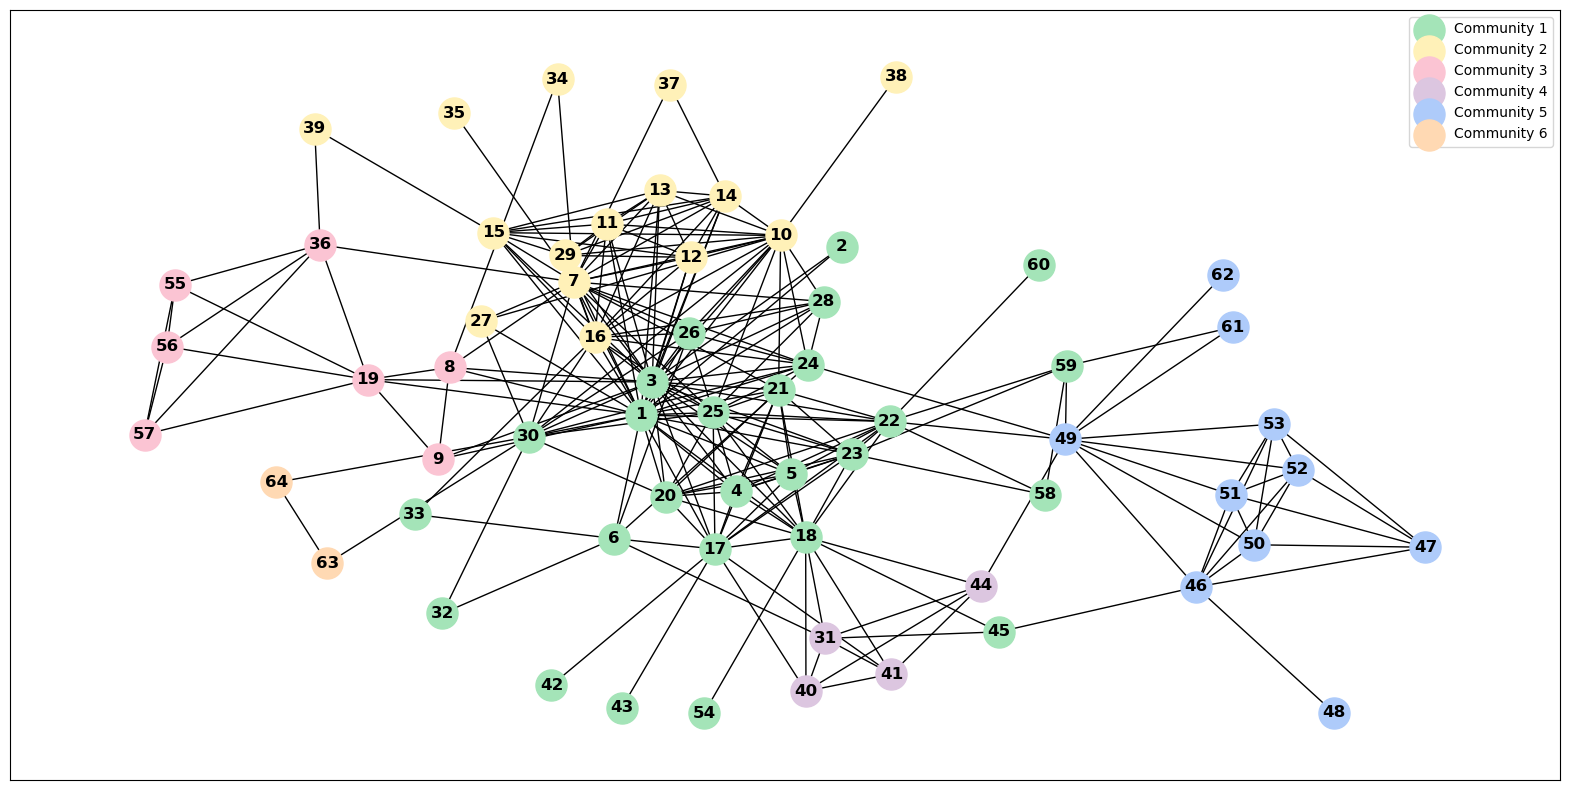

In [56]:
colors = ['#A4E4B8', '#FFF1B8', '#FBC4D3', '#DCC6E0', '#AECBFA', '#FFD9B3']

plt.figure(figsize=(20,10))

for p,c,i in zip(lpa_partition, colors, range(len(lpa_partition))):
    nx.draw_networkx_nodes(G, pos, nodelist=list(p), node_size=500, node_color=colors[i], label=f'Community {i+1}')
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')
plt.legend()
plt.show()

## Homophily test using labed propagation partition

In [57]:
p = [len(cluster) / G.number_of_nodes() for cluster in lpa_partition]
for i in range(len(lpa_partition)):
    for j in range(i+1,len(lpa_partition)):
        # actual crossing-edges
        ac = len([e for e in G.edges if (e[0] in lpa_partition[i]) and (e[1] in lpa_partition[j])]) / G.number_of_edges()
        # expected crossing-edges
        ex = 2 * p[i] * p[j]
        if ac < ex:
            print(f'{round(ac,3)} < {round(ex,3)}: Homophily between clusters {i+1} and {j+1}')
        else:
            print(f'{round(ac,3)} > {round(ex,3)}: No homophily between clusters {i+1} and {j+1}')


0.078 < 0.19: Homophily between clusters 1 and 2
0.025 < 0.089: Homophily between clusters 1 and 3
0.029 < 0.051: Homophily between clusters 1 and 4
0.016 < 0.127: Homophily between clusters 1 and 5
0.008 < 0.025: Homophily between clusters 1 and 6
0.008 < 0.051: Homophily between clusters 2 and 3
0.0 < 0.029: Homophily between clusters 2 and 4
0.0 < 0.073: Homophily between clusters 2 and 5
0.0 < 0.015: Homophily between clusters 2 and 6
0.0 < 0.014: Homophily between clusters 3 and 4
0.0 < 0.034: Homophily between clusters 3 and 5
0.0 < 0.007: Homophily between clusters 3 and 6
0.004 < 0.02: Homophily between clusters 4 and 5
0.0 < 0.004: Homophily between clusters 4 and 6
0.0 < 0.01: Homophily between clusters 5 and 6


# Random graph

## Erdos-Renyi

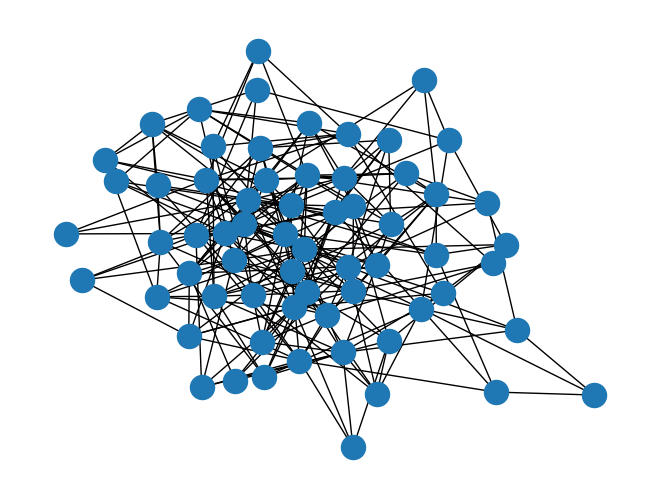

In [58]:
G_er = nx.gnm_random_graph(G.number_of_nodes(), G.number_of_edges())
nx.draw(G_er)

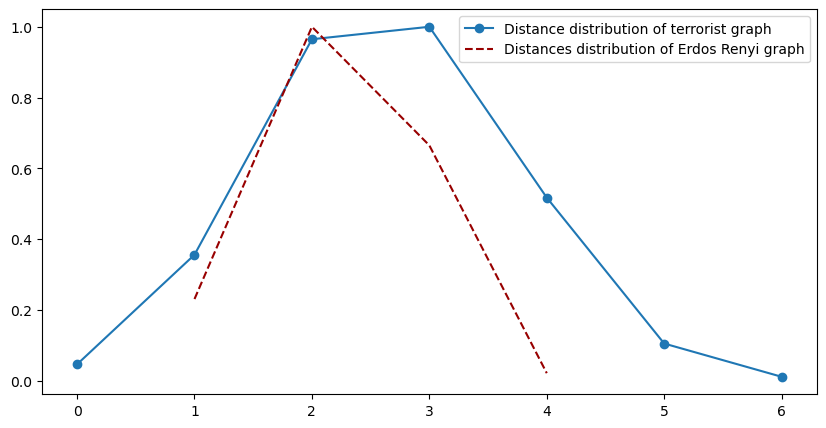

In [59]:
# small world property

all_distances_er = list(np.array([[nx.shortest_path_length(G_er, n1, n2) for n1 in G_er.nodes]for n2 in G_er.nodes]).flatten())
all_distances_er = [d for d in all_distances_er if d != 0]
distances_er = list(set(all_distances_er))
frequency_distances_er = [all_distances_er.count(d) for d in distances_er]
frequency_distances_er = np.array(frequency_distances_er) / max(frequency_distances_er)
plt.figure(figsize=(10,5))
plt.plot(distances, frequency_distances, 'o-', label='Distance distribution of terrorist graph')
plt.plot(distances_er, frequency_distances_er, '--', color='#980000', label='Distances distribution of Erdos Renyi graph')
plt.legend()
plt.show()

In [60]:
# clustering coefficient

print(f'clustering coefficient of terrorist graph = {round(nx.transitivity(G),3)}') 
print(f'clustering coefficient of Erdos-Renyi graph = {round(nx.transitivity(G_er),3)}') 

clustering coefficient of terrorist graph = 0.561
clustering coefficient of Erdos-Renyi graph = 0.103


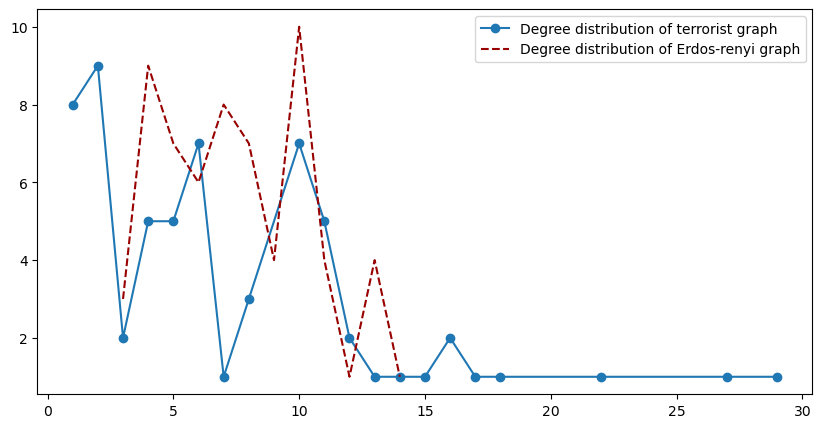

In [61]:
# degree distribution

degree = list(set(dict(G.degree).values()))
frequency_degree = [list(dict(G.degree).values()).count(d) for d in degree]
degree_er = list(set(dict(G_er.degree).values()))
frequency_degree_er = [list(dict(G_er.degree).values()).count(d) for d in degree_er]
plt.figure(figsize=(10,5))
plt.plot(degree, frequency_degree, 'o-', label='Degree distribution of terrorist graph')
plt.plot(degree_er, frequency_degree_er, '--', color='#980000', label='Degree distribution of Erdos-renyi graph')
plt.legend()
plt.show()

## Watts-Strogatz

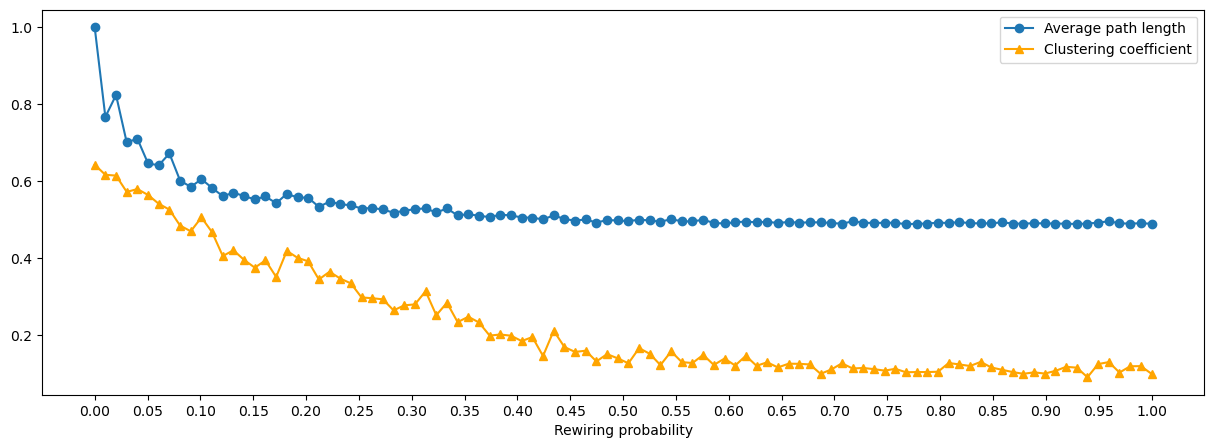

In [62]:
prob = np.linspace(0,1,100)
apl = []
cc =[]
for p in prob:
    G_ws = nx.watts_strogatz_graph(G.number_of_nodes(), 8, p)
    apl.append(nx.average_shortest_path_length(G_ws))
    cc.append(nx.transitivity(G_ws))
plt.figure(figsize=(15,5))
plt.plot(prob, np.array(apl)/max(apl), 'o-', label='Average path length')
plt.plot(prob, cc, '^-', color='orange', label='Clustering coefficient')
plt.xticks(np.linspace(0,1,21))
plt.xlabel('Rewiring probability')
plt.legend()
plt.show()

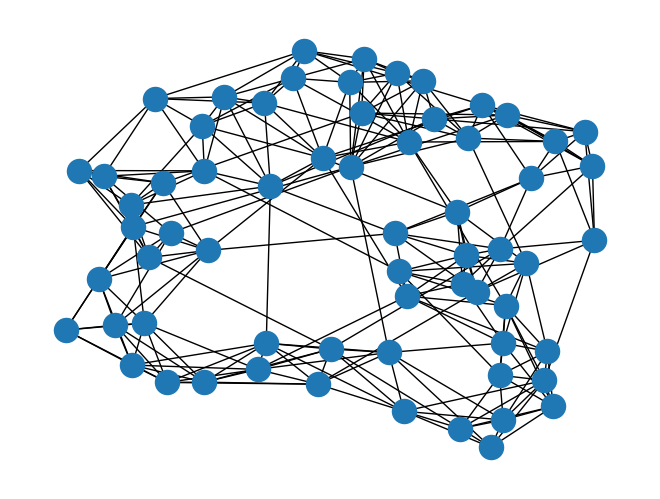

In [63]:
G_ws = nx.watts_strogatz_graph(G.number_of_nodes(), 8, 0.1)
nx.draw(G_ws)

average path length of Watts-Strogatz graph = 2.607638888888889
average path length of terrorist graph = 2.6909722222222223


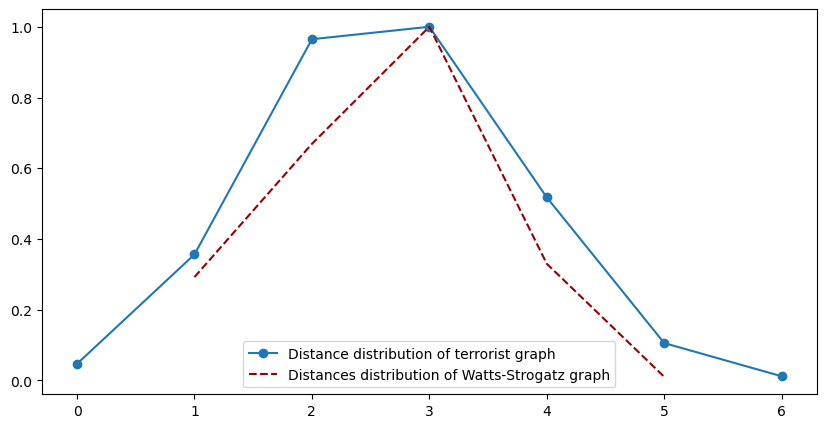

In [64]:
# small world property

print(f'average path length of Watts-Strogatz graph = {nx.average_shortest_path_length(G_ws)}') 
print(f'average path length of terrorist graph = {nx.average_shortest_path_length(G)}') 

all_distances_ws = list(np.array([[nx.shortest_path_length(G_ws, n1, n2) for n1 in G_ws.nodes]for n2 in G_ws.nodes]).flatten())
all_distances_ws = [d for d in all_distances_ws if d != 0]
distances_ws = list(set(all_distances_ws))
frequency_distances_ws = [all_distances_ws.count(d) for d in distances_ws]
frequency_distances_ws = np.array(frequency_distances_ws) / max(frequency_distances_ws)
plt.figure(figsize=(10,5))
plt.plot(distances, frequency_distances, 'o-', label='Distance distribution of terrorist graph')
plt.plot(distances_ws, frequency_distances_ws, '--', color='#980000', label='Distances distribution of Watts-Strogatz graph')
plt.legend()
plt.show()

In [65]:
# clustering coefficient

print(f'clustering coefficient of terrorist graph = {round(nx.transitivity(G),3)}') 
print(f'clustering coefficient of Watts-Strogatz graph = {round(nx.transitivity(G_ws),3)}') 

clustering coefficient of terrorist graph = 0.561
clustering coefficient of Watts-Strogatz graph = 0.457


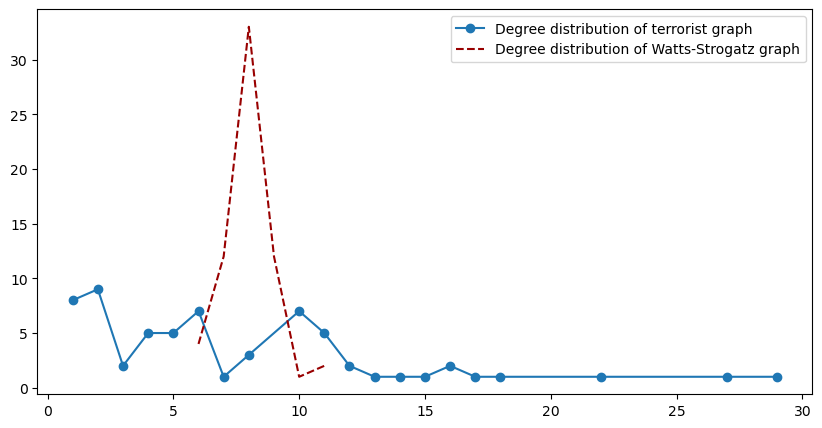

In [66]:
# degree distribution

degree = list(set(dict(G.degree).values()))
frequency_degree = [list(dict(G.degree).values()).count(d) for d in degree]
degree_ws = sorted(list(set(dict(G_ws.degree).values())))
frequency_degree_ws = [list(dict(G_ws.degree).values()).count(d) for d in degree_ws]
plt.figure(figsize=(10,5))
plt.plot(degree, frequency_degree, 'o-', label='Degree distribution of terrorist graph')
plt.plot(degree_ws, frequency_degree_ws, '--', color='#980000', label='Degree distribution of Watts-Strogatz graph')
plt.legend()
plt.show()

## Configuration model

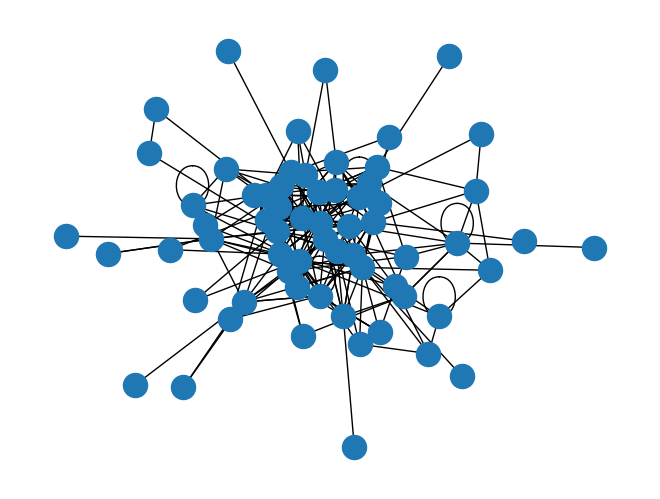

In [67]:
D = dict(G.degree).values()
G_cm = nx.configuration_model(D)
nx.draw(G_cm)

average path length of Configuration model graph = 2.4345238095238093
average path length of terrorist graph = 2.6909722222222223


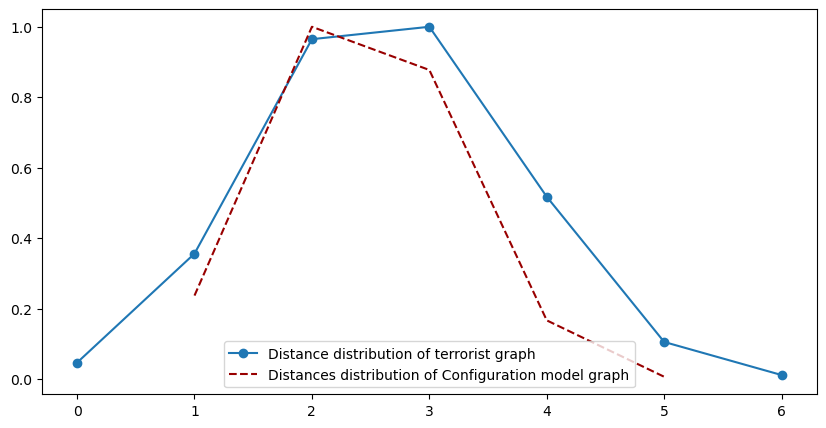

In [68]:
# small world property

print(f'average path length of Configuration model graph = {nx.average_shortest_path_length(G_cm)}') 
print(f'average path length of terrorist graph = {nx.average_shortest_path_length(G)}') 

all_distances_cm = list(np.array([[nx.shortest_path_length(G_cm, n1, n2) for n1 in G_cm.nodes]for n2 in G_cm.nodes]).flatten())
all_distances_cm = [d for d in all_distances_cm if d != 0]
distances_cm = list(set(all_distances_cm))
frequency_distances_cm = [all_distances_cm.count(d) for d in distances_cm]
frequency_distances_cm = np.array(frequency_distances_cm) / max(frequency_distances_cm)
plt.figure(figsize=(10,5))
plt.plot(distances, frequency_distances, 'o-', label='Distance distribution of terrorist graph')
plt.plot(distances_cm, frequency_distances_cm, '--', color='#980000', label='Distances distribution of Configuration model graph')
plt.legend()
plt.show()

In [69]:
# clustering coefficient

print(f'clustering coefficient of terrorist graph = {round(nx.transitivity(G),3)}') 
print(f'clustering coefficient of Configuration model graph = {round(nx.transitivity(G_ws),3)}') 

clustering coefficient of terrorist graph = 0.561
clustering coefficient of Configuration model graph = 0.457


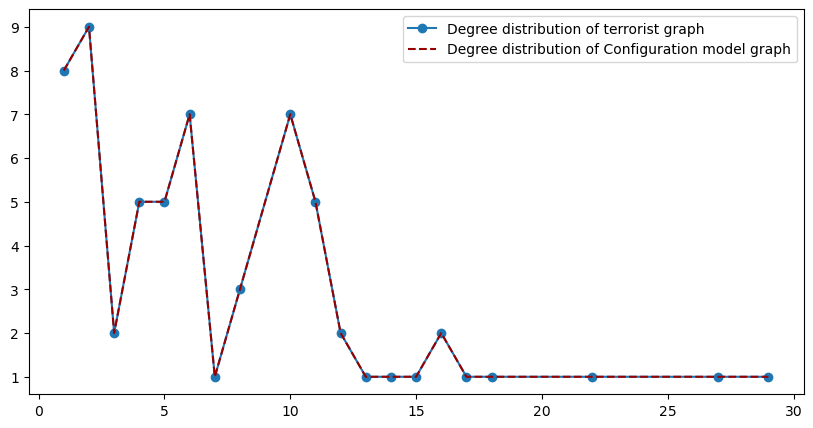

In [70]:
# degree distribution

degree = list(set(dict(G.degree).values()))
frequency_degree = [list(dict(G.degree).values()).count(d) for d in degree]
degree_cm = sorted(list(set(dict(G_cm.degree).values())))
frequency_degree_cm = [list(dict(G_cm.degree).values()).count(d) for d in degree_cm]
plt.figure(figsize=(10,5))
plt.plot(degree, frequency_degree, 'o-', label='Degree distribution of terrorist graph')
plt.plot(degree_cm, frequency_degree_cm, '--', color='#980000', label='Degree distribution of Configuration model graph')
plt.legend()
plt.show()

## Barabasi-Albert

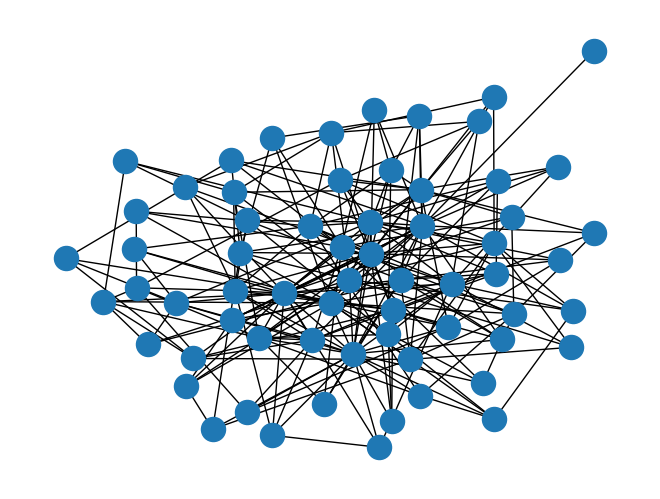

In [71]:
G_ba = nx.barabasi_albert_graph(G.number_of_nodes(), 4)
nx.draw(G_ba)

average path length of Barabasi-Albert model graph = 2.1999007936507935
average path length of terrorist graph = 2.6909722222222223


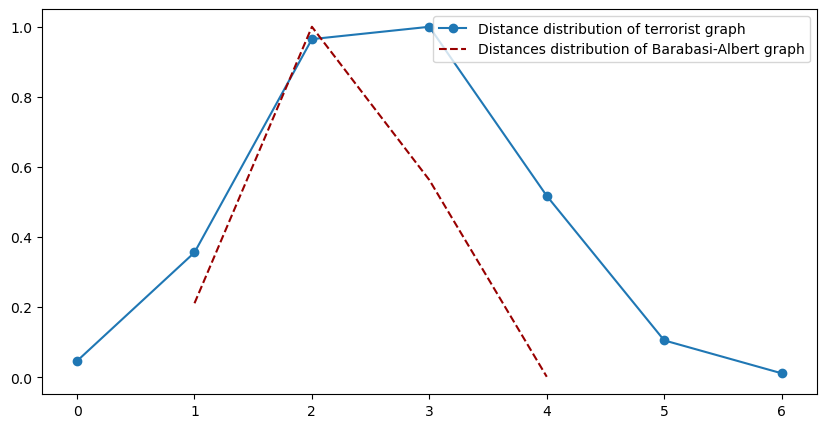

In [72]:
# small world property

print(f'average path length of Barabasi-Albert model graph = {nx.average_shortest_path_length(G_ba)}') 
print(f'average path length of terrorist graph = {nx.average_shortest_path_length(G)}') 

all_distances_ba = list(np.array([[nx.shortest_path_length(G_ba, n1, n2) for n1 in G_ba.nodes]for n2 in G_ba.nodes]).flatten())
all_distances_ba = [d for d in all_distances_ba if d != 0]
distances_ba = list(set(all_distances_ba))
frequency_distances_ba = [all_distances_ba.count(d) for d in distances_ba]
frequency_distances_ba = np.array(frequency_distances_ba) / max(frequency_distances_ba)
plt.figure(figsize=(10,5))
plt.plot(distances, frequency_distances, 'o-', label='Distance distribution of terrorist graph')
plt.plot(distances_ba, frequency_distances_ba, '--', color='#980000', label='Distances distribution of Barabasi-Albert graph')
plt.legend()
plt.show()

In [73]:
# clustering coefficient

print(f'clustering coefficient of terrorist graph = {round(nx.transitivity(G),3)}') 
print(f'clustering coefficient of Barabasi-Albert model graph = {round(nx.transitivity(G_ba),3)}') 

clustering coefficient of terrorist graph = 0.561
clustering coefficient of Barabasi-Albert model graph = 0.194


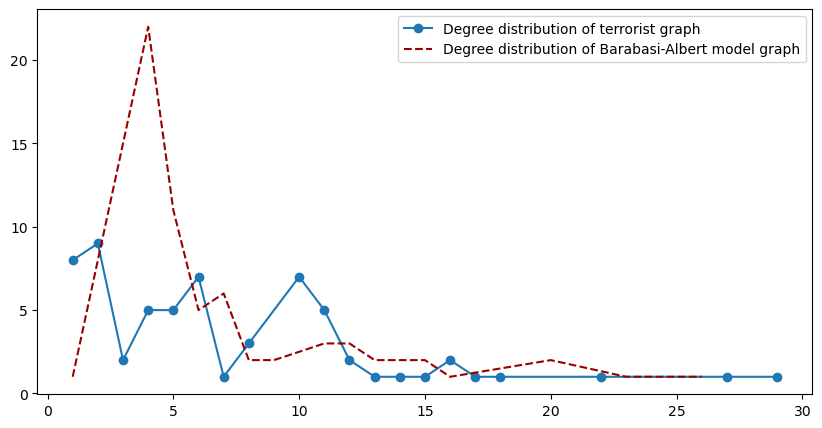

In [74]:
# degree distribution

degree = list(set(dict(G.degree).values()))
frequency_degree = [list(dict(G.degree).values()).count(d) for d in degree]
degree_ba = sorted(list(set(dict(G_ba.degree).values())))
frequency_degree_ba = [list(dict(G_ba.degree).values()).count(d) for d in degree_ba]
plt.figure(figsize=(10,5))
plt.plot(degree, frequency_degree, 'o-', label='Degree distribution of terrorist graph')
plt.plot(degree_ba, frequency_degree_ba, '--', color='#980000', label='Degree distribution of Barabasi-Albert model graph')

plt.legend()
plt.show()